# Group Connection Testing


In this notebook we will be testing whether the hemispheres/segments come from an stochastic block model, which models graphs containing communities, in which subsets of nodes within each community are characterized as being connected to each other with particular edge densities. Here, our communities are determined by the classes of the neurons within each hemisphere/segment, which we are considering can be interneuron, motorneuron, or sensory neuron.

In [1]:
import logging
import pandas as pd
import numpy as np
import csv
import networkx as nx
import itertools
import seaborn as sns
from pathlib import Path
from networkx import from_pandas_adjacency
from itertools import chain, combinations
from matplotlib import pyplot as plt
from collections import namedtuple
from graspologic.inference import group_connection_test
from graspologic.plot import heatmap, adjplot
from pkg.stats import stochastic_block_test, stochastic_block_test_paired
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations_v3, load_left_adj, load_right_adj, load_head_adj, load_pygidium_adj, load_0_adj, load_1_adj, load_2_adj, load_3_adj


         7501  10536  6743  151847  12115  11135  11731  13459  14162  58877  \
7501      0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10536     1.0    0.0   2.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6743      0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
151847    0.0    0.0   1.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12115     0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    1.0   
...       ...    ...   ...     ...    ...    ...    ...    ...    ...    ...   
1310016   0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1732125   0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1415385   0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
708228    0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
941766    0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         ...  1420496  135113  1797187 

In [2]:
folder = _get_folder()
folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs/7_24_23')

In [3]:
annotations = load_connectome_normal_lcc_annotations_v3()
annotations

,skids,side,class,segment,type,group
0,2015233,left,sensory,head,100.0,NaN
1,1548290,left,muscle,1,NaN,NaN
2,1318919,left,sensory,head,88.0,15.0
3,2015241,left,sensory,head,100.0,NaN
4,1769485,right,sensory,NaN,NaN,NaN
...,...,...,...,...,...,...
2028,1597423,right,muscle,pygidium,NaN,NaN
2029,1302513,left,sensory,head,NaN,NaN
2030,1671147,right,motor,1,165.0,NaN
2031,1376251,left,inter,head,NaN,NaN


The following blocks of code generate dataframes, where the skids_df represent the skids of interest in the hemispheres/segments and labels_df represent the corresponding labels of the classes of the neurons

In [4]:
#get indices from left and right
skids_hemis = {"left": [], "right": []}
skids_hemis_list = []
for key in skids_hemis:
    for i in range(len(annotations["skids"])):
        if annotations["side"][i] == key:
            skids_hemis[key].append(annotations["skids"][i])
            skids_hemis_list.append(annotations["skids"][i])
skids_hemis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_hemis.items()]))
#skids_hemis_df.to_csv(folder / "skids_hemis_v3.csv")
skids_hemis_df
            

,left,right
0,2015233,1769485.0
1,1548290,1622033.0
2,1318919,2007060.0
3,2015241,1064990.0
4,1564703,1728563.0
...,...,...
1039,1277932,NaN
1040,1630186,NaN
1041,1302513,NaN
1042,1376251,NaN


In [5]:
skids_hemis_with_class = {"left": [], "right": []}
labels_hemis_with_class = {"left": [], "right": []}
poss_labels = ["sensory", "inter", "motor", "muscle", "epithelia", "ciliated"]

#add skids and labels for hemis;
for key in skids_hemis_with_class:
    for i in range(len(annotations["skids"])):

        #check if the skid is in the left/right adj (normal, lcc), and the side is left or right, and the class exists as sensory, motor, or inter
        if(annotations["skids"][i] in skids_hemis_list and annotations["side"][i]==key and annotations["class"][i] in poss_labels):
            skids_hemis_with_class[key].append(annotations["skids"][i])
            labels_hemis_with_class[key].append(annotations["class"][i])

#convert dicts to dataframes
skids_hemis_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_hemis_with_class.items()]))
labels_hemis_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_hemis_with_class.items()]))
#skids_hemis_with_class_df.to_csv(folder / "skids_hemis_classes_v3.csv")
#labels_hemis_with_class_df.to_csv(folder / "labels_hemis_classes_v3.csv")

print(len(skids_hemis_with_class["left"]))
print(len(skids_hemis_with_class["right"]))

967
919


In [6]:
#get indices from left and right
skids_segs = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}
skids_segs_list = []

for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if annotations["segment"][i] == key:
            skids_segs[key].append(annotations["skids"][i])
            skids_segs_list.append(annotations["skids"][i])
skids_segs_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_segs.items()]))
#skids_segs_df.to_csv(folder / "skids_segs_v3.csv")
skids_segs_df

,head,pygidium,1,2,3
0,2015233,1278185.0,1548290.0,1728563.0,1622033.0
1,1318919,1335777.0,1458234.0,1466424.0,1728550.0
2,2015241,1335790.0,1433691.0,1065030.0,1417265.0
3,2007060,1335807.0,1376350.0,1441872.0,1417276.0
4,1064990,1335832.0,1433701.0,1646725.0,1507391.0
...,...,...,...,...,...
742,2015193,NaN,NaN,NaN,NaN
743,180202,NaN,NaN,NaN,NaN
744,1343467,NaN,NaN,NaN,NaN
745,1302513,NaN,NaN,NaN,NaN


In [7]:
skids_segs_with_class = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}
labels_segs_with_class = {"head": [], "pygidium": [], "1": [], "2": [], "3": []}

for key in skids_segs:
    for i in range(len(annotations["skids"])):
        if(annotations["skids"][i] in skids_segs_list and annotations["segment"][i]==key and annotations["class"][i] in poss_labels):
            skids_segs_with_class[key].append(annotations["skids"][i])
            labels_segs_with_class[key].append(annotations["class"][i])

skids_segs_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in skids_segs_with_class.items()]))
labels_segs_with_class_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in labels_segs_with_class.items()]))
#skids_segs_with_class_df.to_csv(folder / "skids_segs_classes_v3.csv")
#labels_segs_with_class_df.to_csv(folder / "labels_segs_classes_v3.csv")
print(len(skids_segs_with_class["pygidium"]))

79


In [8]:
new_folder = Path.joinpath(folder, "group_connection_plots")
new_folder

PosixPath('/Users/kareefullah/Desktop/NeuroData/neurodata/platy-data/docs/outputs/7_24_23/group_connection_plots')

In [9]:
#comparison for hemis
count_hemis = {"left" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0}, "right": {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0}}

for key in count_hemis:
    for i in range(len(labels_hemis_with_class[key])):
        count_hemis[key][labels_hemis_with_class[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "sensory", "inter", "motor", "muscle", "epithelia", "ciliated"
list_counts_hemis = []
class_label_hemis = []
hemi_label = []
class_label_full = ["Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated"]
# loop through "left" and "right"
for key in count_hemis:
    # loop through "sensory", "inter", "motor", "muscle", "epithelia", "ciliated"
    for inner_key in count_hemis[key]:
        # append "Sensory", "Inter", "Motor", "Muscle, "Epithelia", "Ciliated" depending on inner key
        for i in range(len(class_label_full)):
            if inner_key == class_label_full[i].lower():
                class_label_hemis.append(class_label_full[i])
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_hemis.append(count_hemis[key][inner_key])
        # append the outer key from count_hemis
        hemi_label.append(key)

label_counts = list(zip(class_label_hemis, list_counts_hemis, hemi_label))
df_hemis = pd.DataFrame(label_counts, columns = ["class", "count", "side"])
#df_hemis.to_csv(new_folder / "hemi_classes_counts_v2.csv")
df_hemis

,class,count,side
0,Sensory,249,left
1,Inter,382,left
2,Motor,100,left
3,Muscle,185,left
4,Epithelia,15,left
5,Ciliated,36,left
6,Sensory,239,right
7,Inter,381,right
8,Motor,105,right
9,Muscle,146,right


We make barplots for the counts of each of the classes across the hemispheres/segments using the dictionaries we generated above

Text(0.5, 1.0, 'counts of classes across hemis')

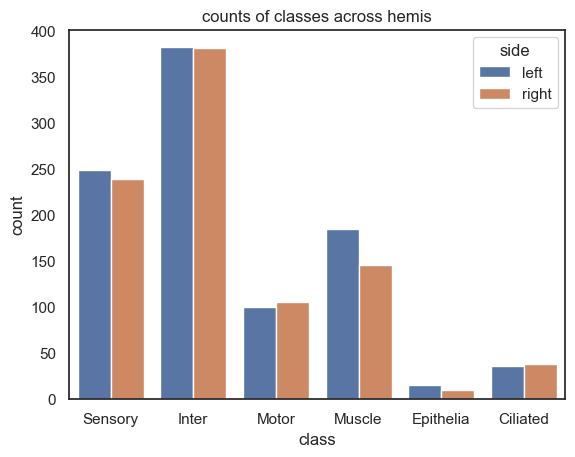

In [10]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="side", data=df_hemis)
plt.title("counts of classes across hemis")
#plt.savefig(new_folder / "hemi_classes_barplot_v2.png")

In [11]:

#comparison for segments
count_segs = {"head" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},
              "1" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},
              "2" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},
              "3" : {"sensory": 0, "inter": 0, "motor": 0, "muscle": 0, "epithelia": 0, "ciliated": 0},}

for key in count_segs:
    for i in range(len(labels_segs_with_class[key])):
        count_segs[key][labels_segs_with_class[key][i]] += 1

# get the lists of number of skids for y values, x values are the keys
keys = poss_labels # "sensory", "inter", "motor", "muscle", "epithelia", "ciliated"
list_counts_segs = []
class_label_segs = []
segs_label = []
# loop through segments
for key in count_segs:
    # loop through inner keys
    for inner_key in count_segs[key]:
        # append "Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated" depending on inner key
        for i in range(len(class_label_full)):
            if inner_key == class_label_full[i].lower():
                class_label_segs.append(class_label_full[i])
        # add 1 to the count of the respective class label in the respective key of count_hemis
        list_counts_segs.append(count_segs[key][inner_key])
        # append the outer key from count_hemis
        segs_label.append(key)

label_counts_segs = list(zip(class_label_segs, list_counts_segs, segs_label))
df_segs = pd.DataFrame(label_counts_segs, columns = ["class", "count", "segment"])
#df_segs.to_csv(new_folder / "segs_classes_counts_v2.csv")
df_segs

,class,count,segment
0,Sensory,314,head
1,Inter,343,head
2,Motor,22,head
3,Muscle,7,head
4,Epithelia,5,head
5,Ciliated,33,head
6,Sensory,33,1
7,Inter,124,1
8,Motor,53,1
9,Muscle,97,1


Text(0.5, 1.0, 'counts of classes across segments')

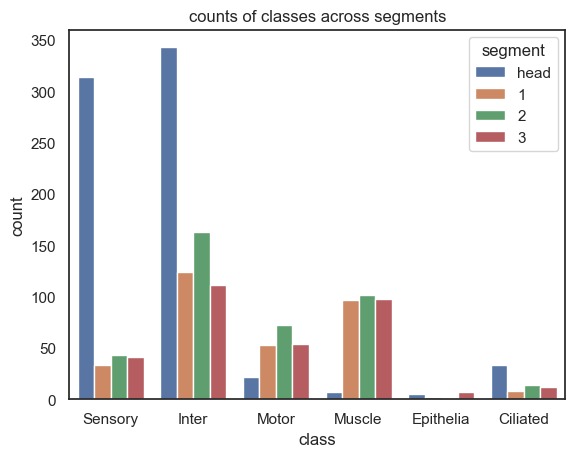

In [12]:
sns.set(style="white")
sns.barplot(x="class", y="count", hue="segment", data=df_segs)
plt.title("counts of classes across segments")
#plt.savefig(new_folder / "segs_classes_barplot.png")

We will now visualize the adjs of the hemispheres/segments, in which the nodes will be grouped into communities of sensory, motor, or interneurons

In [13]:
#block for loading adjs/labels
from pkg.platy import load_left_adj_labels_with_class_v3, load_right_adj_labels_with_class_v3, load_head_adj_labels_with_class_v3, load_pygidium_adj_labels_with_class_v3, load_1_adj_labels_with_class_v3, load_2_adj_labels_with_class_v3, load_3_adj_labels_with_class_v3, load_best_left_adj_with_class_align, load_best_right_adj_with_class_align
#hemis
left_adj, left_labels = load_left_adj_labels_with_class_v3()
right_adj, right_labels = load_right_adj_labels_with_class_v3()
best_left_adj, best_left_labels = load_best_left_adj_with_class_align()
best_right_adj, best_right_labels = load_best_right_adj_with_class_align()

#segments
head_adj, head_labels = load_head_adj_labels_with_class_v3()
pyg_adj, pyg_labels = load_pygidium_adj_labels_with_class_v3()
#adj_0, labels_0 = load_0_adj_labels()
adj_1, labels_1 = load_1_adj_labels_with_class_v3()
adj_2, labels_2 = load_2_adj_labels_with_class_v3()
adj_3, labels_3 = load_3_adj_labels_with_class_v3()
print(len(best_right_adj))

771


In [14]:
#NOTE: ADD BEST LEFT AND RIGHT AND PLOT SCATTERS
#lists for adjs/labels/names
hemi_adjs = [left_adj, right_adj]
for i, val in enumerate(hemi_adjs):
    hemi_adjs[i] = val.to_numpy()

hemi_best_adjs = [best_left_adj, best_right_adj]
for i, val in enumerate(hemi_best_adjs):
    hemi_best_adjs[i] = val.to_numpy()

segment_adjs = [head_adj, pyg_adj, adj_1, adj_2, adj_3]
for i, val in enumerate(segment_adjs):
    segment_adjs[i] = val.to_numpy()
all_adjs = hemi_adjs + hemi_best_adjs + segment_adjs

hemi_labels = [left_labels, right_labels]
hemi_best_labels = [best_left_labels, best_right_labels]
segment_labels = [head_labels, pyg_labels, labels_1, labels_2, labels_3]
all_labels = hemi_labels + hemi_best_labels + segment_labels

hemi_names = ["left", "right"]
hemi_best_names = ["left best", "right best"]
segment_names = ["head", "pygidium", "1", "2", "3"]
all_names = hemi_names + hemi_best_names + segment_names

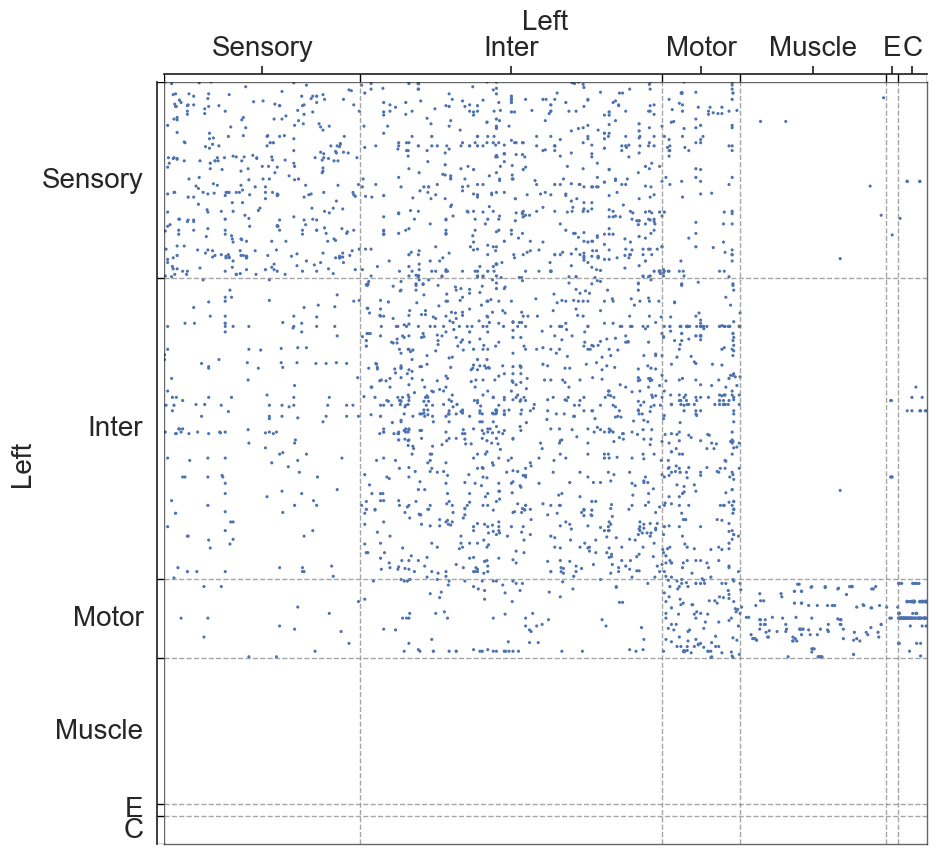

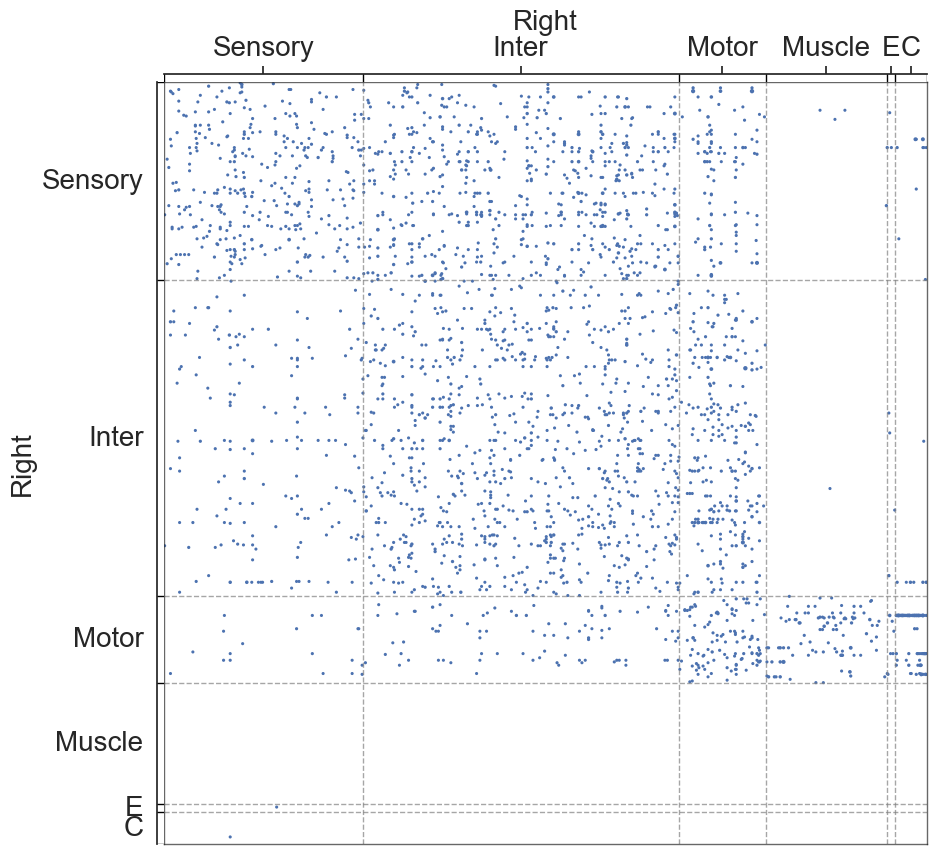

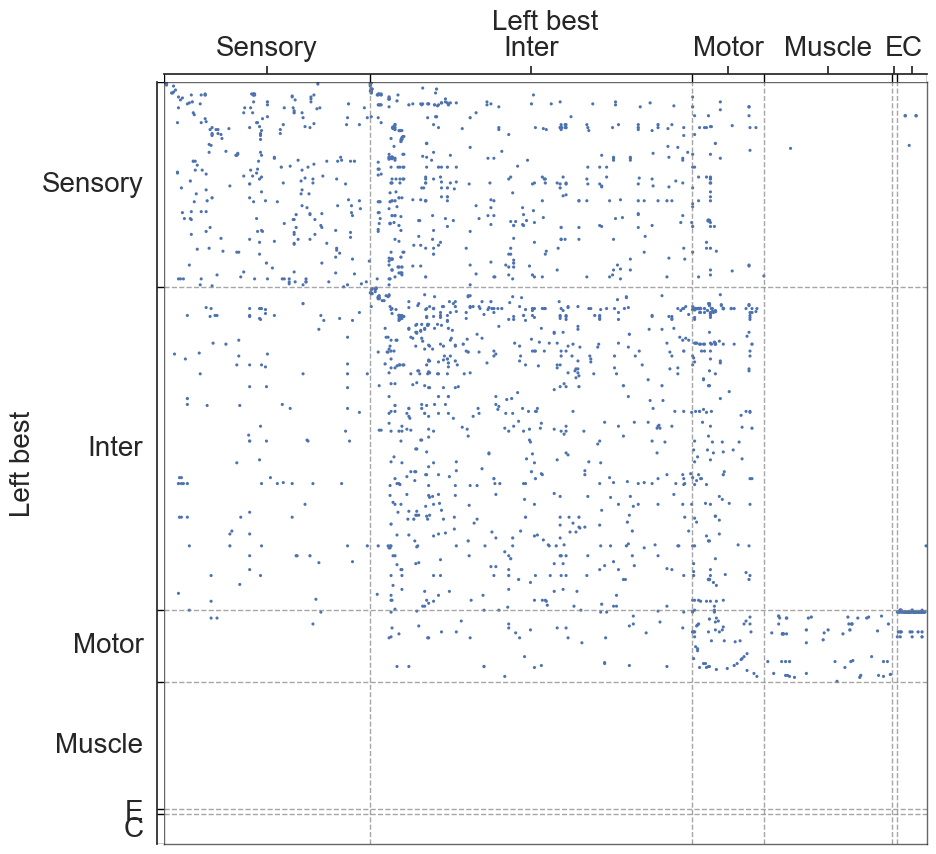

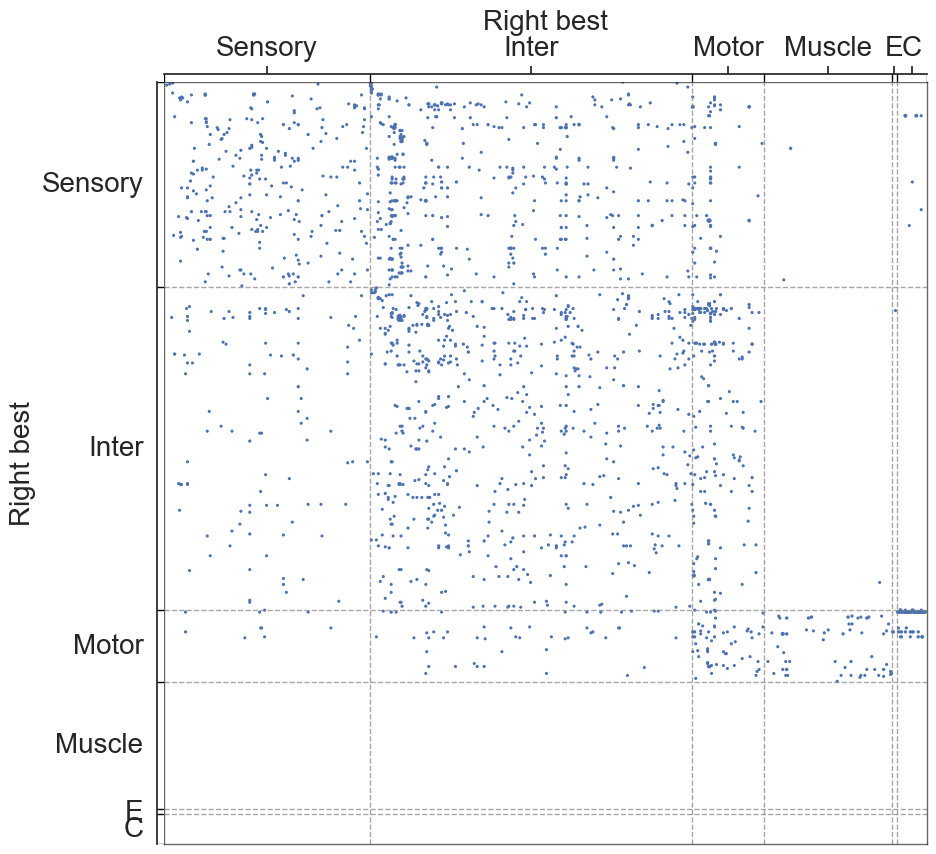

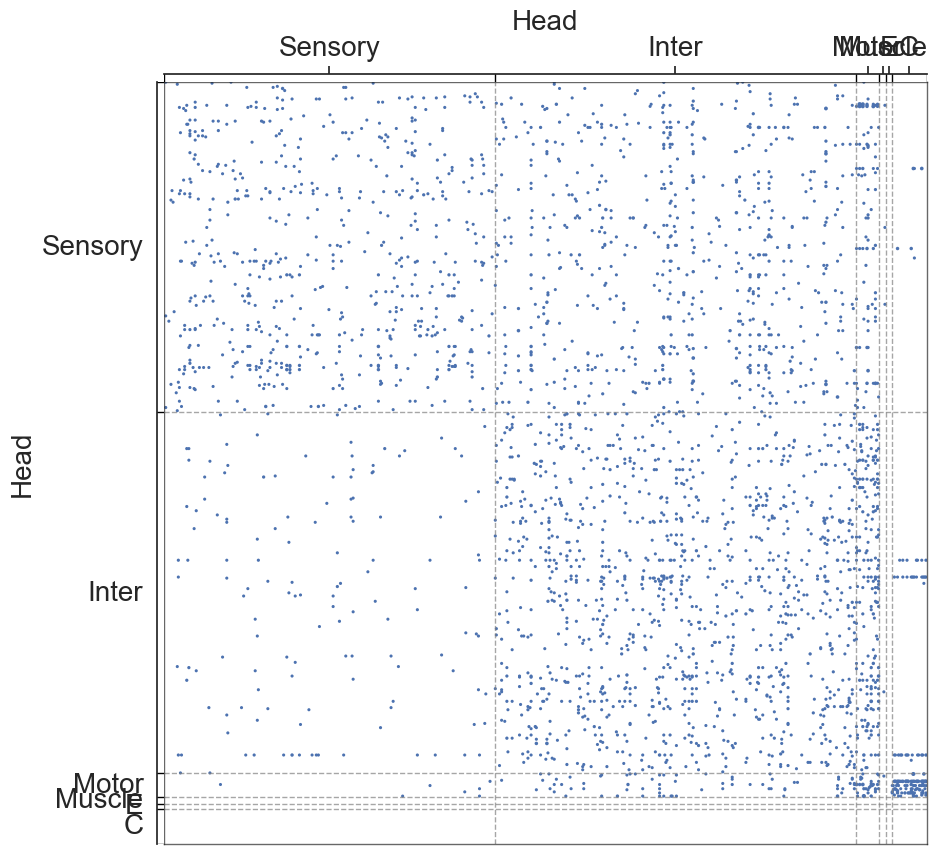

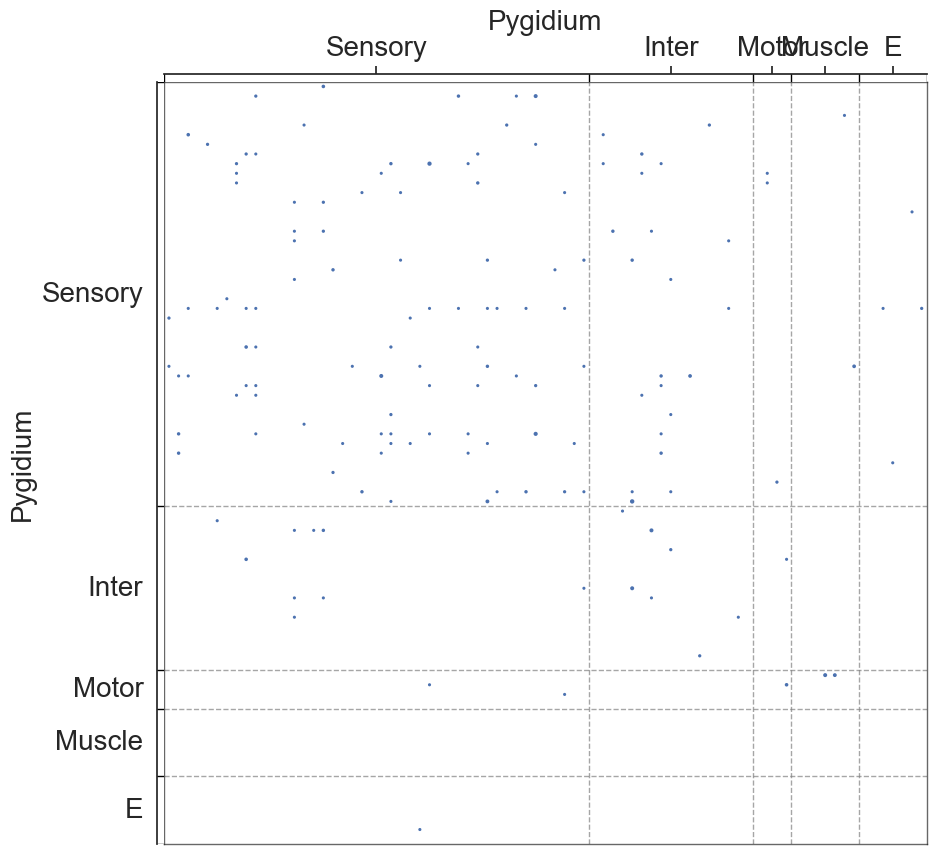

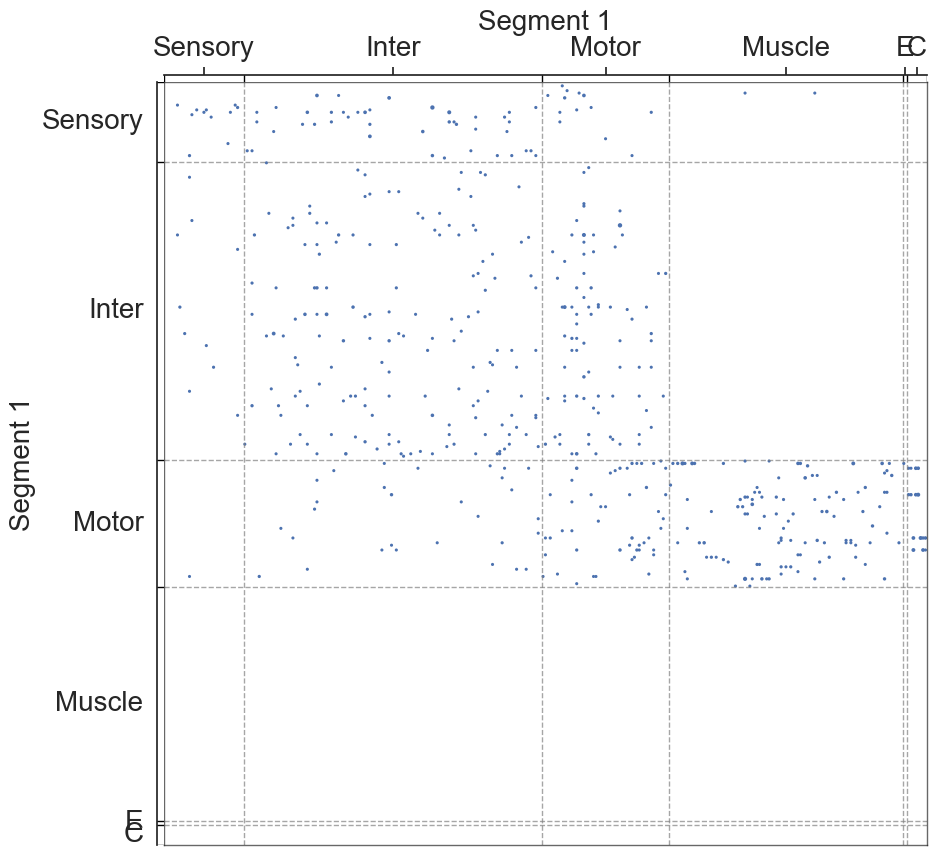

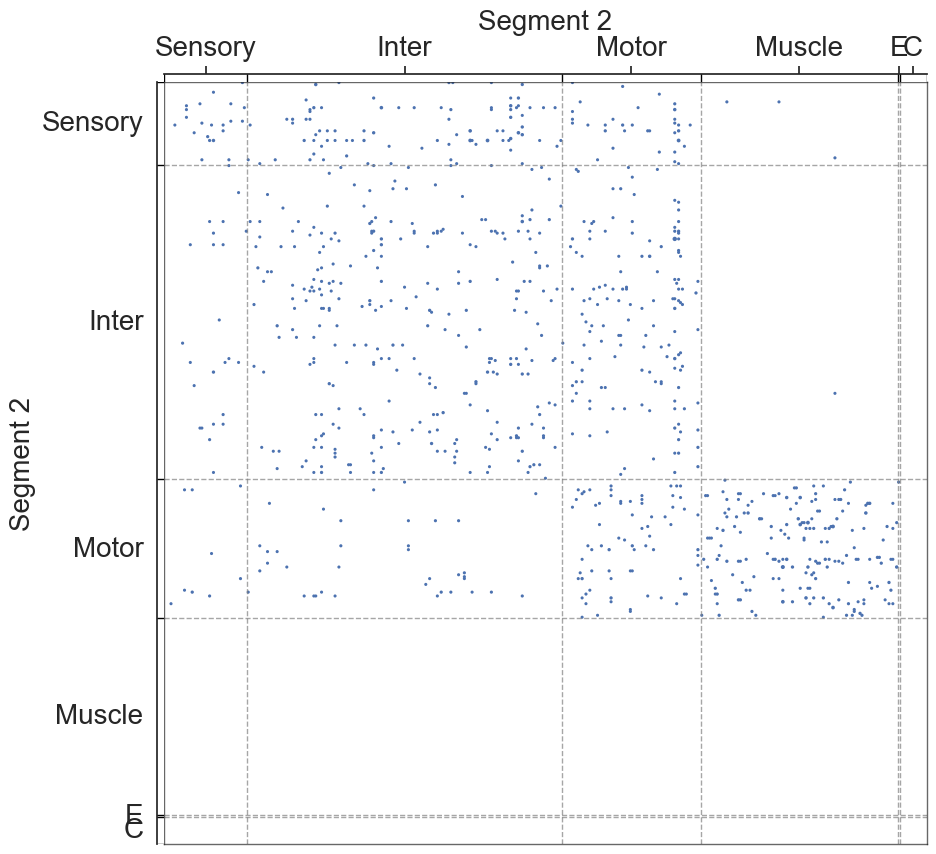

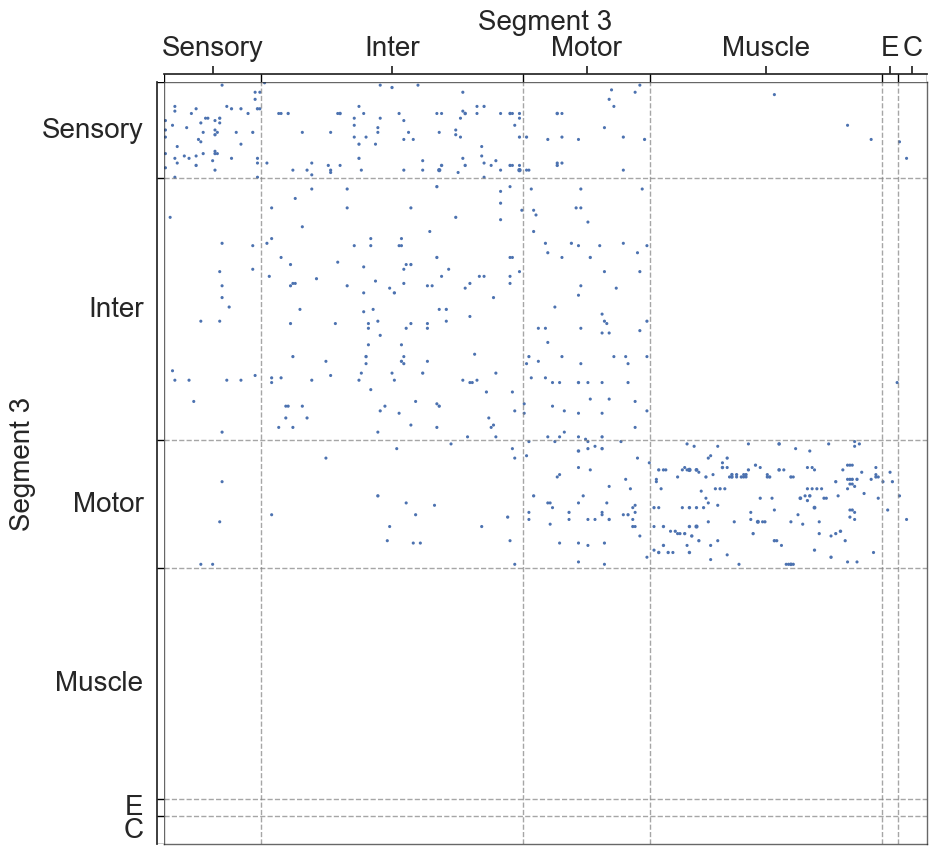

In [15]:
#scatterplots

#format segment names
all_names_format = []
for i in range(len(all_names)):
    if(all_names[i].isnumeric()):
        all_names_format.append(f"Segment {all_names[i]}")

    else:
        all_names_format.append(all_names[i].capitalize())
#metadata
metas = []
for i in range(len(all_adjs)):

    label_list = []
    order_list = []
    for j in range(len(all_labels[i])):

        if all_labels[i][j] == "sensory":
            label_list.append("Sensory")
            order_list.append(0)

        elif all_labels[i][j] == "inter":
            label_list.append("Inter")
            order_list.append(1)
        
        elif all_labels[i][j] == "motor":
            label_list.append("Motor")
            order_list.append(2)
        
        elif all_labels[i][j] == "muscle":
            label_list.append("Muscle")
            order_list.append(3)
        
        elif all_labels[i][j] == "epithelia":
            label_list.append("E")
            order_list.append(4)
        
        elif all_labels[i][j] == "ciliated":
            label_list.append("C")
            order_list.append(5)


    metas.append(pd.DataFrame(
        data={
              "{}".format(all_names_format[i]): label_list,
              "{}_order".format(all_names_format[i]): order_list
        },
))

for i in range(len(all_adjs)):
    #group_order parameter - make all s have group order 0 etc
    ax, _ = adjplot(all_adjs[i], plot_type="scattermap", meta=metas[i], group=["{}".format(all_names_format[i])], group_order=["{}_order".format(all_names_format[i])])
    #plt.savefig(new_folder / "scatterplots" / "connection_{}".format(all_names[i]))


In [16]:
print(len(metas[2]))
print(len(all_adjs[2]))

771
771


Group Connection Test for Left and Right Hemispheres

In [17]:
stat, pval, misc = stochastic_block_test(hemi_adjs[0], hemi_adjs[1], hemi_labels[0], hemi_labels[1])
pval

0.023238378414930802

In [18]:
#NOTE: RUN TEST FOR BEST LEFT AND RIGHT UNPAIRED
stat_best, pval_best, misc_best = stochastic_block_test(hemi_best_adjs[0], hemi_best_adjs[1], hemi_best_labels[0], hemi_best_labels[1])
pval_best

0.9419105944214755

In [19]:
#NOTE: RUN TEST FOR BEST LEFT AND RIGHT PAIRED
stat_best, pval_best, misc_best = stochastic_block_test_paired(hemi_best_adjs[0], hemi_best_adjs[1], hemi_best_labels[0])
pval_best

0.9996825383557381

We do the same for all the pairwise combinations of segments

In [20]:
#get rid of pygidium in analysis since it does not have epithlia or ciliated
segment_adjs = [head_adj, adj_1, adj_2, adj_3]
segment_labels = [head_labels, labels_1, labels_2, labels_3]
segment_names = ["head", "1", "2", "3"]

pairwise_labels = list(itertools.combinations(segment_labels, 2))
pairwise_adjs = list(itertools.combinations(segment_adjs, 2))
pairwise_names = list(itertools.combinations(segment_names, 2))
#initialize dataframe
zero_data = np.zeros(shape=(len(segment_names), len(segment_names)))
pval_df = pd.DataFrame(zero_data, columns=segment_names, index=segment_names)
pval_list = []

thres = 1e-12
for label, adjs, name in zip(pairwise_labels, pairwise_adjs, pairwise_names):
    np_adj0 = np.array(adjs[0])
    np_adj1 = np.array(adjs[1])
    stat, pval, misc = group_connection_test(np_adj0, np_adj1, label[0], label[1])
    #lower limit
    if pval<thres:
        pval = thres
    
    pval_df[name[0]][name[1]] = pval
    pval_df[name[1]][name[0]] = pval

#pval_df.to_csv(new_folder  / "group_connection_test_pvals_segments_v2.csv")
pval_df

/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)
/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:376: UserWarning: This test assumes that the networks are loopless, but one or both adjacency matrices have self-loops.Test will be run on the loopless version of these adjacency matrices.
  warnings.warn(msg)
/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)
/Users/kareefullah/Desktop/NeuroData/neurodata/grasp

,head,1,2,3
head,0.000000e+00,9.582790e-09,1.000000e-12,1.000000e-12
1,9.582790e-09,0.000000e+00,6.575598e-01,4.590601e-04
2,1.000000e-12,6.575598e-01,0.000000e+00,2.254506e-04
3,1.000000e-12,4.590601e-04,2.254506e-04,0.000000e+00


Let's use bonferroni's correction on the segment p-values to reduce the chances of obtaining false positive results since we are using multiple pairwise tests

In [21]:
#bonferroni correction for non-density adjusted p-vals
from statsmodels.stats.multitest import multipletests
np_pvals = pval_df.to_numpy().flatten()
corrected_pvals = multipletests(np_pvals)[1].reshape((len(segment_names), len(segment_names)))
pvals_df_bonferroni_corrected = pd.DataFrame(corrected_pvals, columns=segment_names, index=segment_names)
pvals_df_bonferroni_corrected

,head,1,2,3
head,0.000000e+00,7.666232e-08,1.200000e-11,1.200000e-11
1,7.666232e-08,0.000000e+00,8.827347e-01,1.834976e-03
2,1.200000e-11,8.827347e-01,0.000000e+00,1.351941e-03
3,1.200000e-11,1.834976e-03,1.351941e-03,0.000000e+00


Now, let's use the density adjusted version of group connection tests, which accounts for the potential difference in density across the adjs (are the group-to-group connection probabilities of one adj simply a scaled-up version of those of the other)

In [22]:
stat, pval, misc = stochastic_block_test(hemi_adjs[0], hemi_adjs[1], hemi_labels[0], hemi_labels[1], density_adjustment=True)
pval

0.028791966863513103

In [23]:
#NOTE: RUN TEST FOR BEST LEFT AND RIGHT UNPAIRED
stat_best, pval_best, misc_best = stochastic_block_test(hemi_best_adjs[0], hemi_best_adjs[1], hemi_best_labels[0], hemi_best_labels[1], density_adjustment=True)
pval_best

0.9541094917452053

In [24]:
#NOTE: RUN TEST FOR BEST LEFT AND RIGHT PAIRED
#stat_best, pval_best, misc_best = stochastic_block_test_paired(hemi_best_adjs[0], hemi_best_adjs[1], hemi_best_labels[0], density_adjustment=True)
#pval_best

In [25]:
pairwise_labels = list(itertools.combinations(segment_labels, 2))
pairwise_adjs = list(itertools.combinations(segment_adjs, 2))
pairwise_names = list(itertools.combinations(segment_names, 2))
#initialize dataframe
zero_data = np.zeros(shape=(len(segment_names), len(segment_names)))
pval_df_density_correct = pd.DataFrame(zero_data, columns=segment_names, index=segment_names)
pval_list = []
for label, adjs, name in zip(pairwise_labels, pairwise_adjs, pairwise_names):
    np_adj0 = np.array(adjs[0])
    np_adj1 = np.array(adjs[1])
    stat, pval, misc = group_connection_test(np_adj0, np_adj1, label[0], label[1], density_adjustment=True)

    #lower limit
    if pval<thres:
        pval = thres
        
    pval_df_density_correct[name[0]][name[1]] = pval
    pval_df_density_correct[name[1]][name[0]] = pval
#pval_df_density_correct.to_csv(folder / "group_connection_plots" / "group_connection_test_pvals_segments_density_adjust_v2.csv")
pval_df_density_correct

/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)
/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:376: UserWarning: This test assumes that the networks are loopless, but one or both adjacency matrices have self-loops.Test will be run on the loopless version of these adjacency matrices.
  warnings.warn(msg)
/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)
/Users/kareefullah/Desktop/NeuroData/neurodata/grasp

,head,1,2,3
head,0.000000e+00,4.478638e-07,1.000000e-12,1.000000e-12
1,4.478638e-07,0.000000e+00,5.804884e-01,1.007764e-04
2,1.000000e-12,5.804884e-01,0.000000e+00,3.604473e-04
3,1.000000e-12,1.007764e-04,3.604473e-04,0.000000e+00


Using Bonferroni's correction for the density adjusted segments:

In [26]:
np_pvals_density_correct = pval_df_density_correct.to_numpy().flatten()
corrected_pvals_density_correct = multipletests(np_pvals_density_correct)[1].reshape((len(segment_names), len(segment_names)))
pvals_df_density_corrected_bonferroni_corrected = pd.DataFrame(corrected_pvals_density_correct, columns=segment_names, index=segment_names)
pvals_df_density_corrected_bonferroni_corrected

,head,1,2,3
head,0.000000e+00,0.000004,1.200000e-11,1.200000e-11
1,3.582905e-06,0.000000,8.240100e-01,6.045063e-04
2,1.200000e-11,0.824010,0.000000e+00,1.441010e-03
3,1.200000e-11,0.000605,1.441010e-03,0.000000e+00


The following functions will allow us to visualize the p-values of the segments in a heatmap, where significant p-values are denoted with an X

In [27]:
from matplotlib.transforms import Bbox
def shrink_axis(ax, scale=0.7, shift=0):
    pos = ax.get_position()
    mid = (pos.ymax + pos.ymin) / 2
    height = pos.ymax - pos.ymin
    new_pos = Bbox(
        [
            [pos.xmin, mid - scale * 0.5 * height - shift],
            [pos.xmax, mid + scale * 0.5 * height - shift],
        ]
    )
    ax.set_position(new_pos)

In [28]:
import matplotlib as mpl
#cmap = mpl.colormaps["RdBu"]

In [29]:
from seaborn.utils import relative_luminance
from pkg.plot import bound_texts
import matplotlib as mpl
def plot_pvals(df, names, density_correct=True, bonferroni_correct=False, ax=None, thres=None, title=None, check_diag = False):
    if ax is None:
        width_ratios = [0.5, 3, 10]
        fig, axs = plt.subplots(
            1,
            3,
            figsize=(10, 10),
            gridspec_kw=dict(
                width_ratios=width_ratios,
            ),
        )
        axs[1].remove()
        ax = axs[-1]
        cax = axs[0]
    
    #take the log10 of all the pvals
    plot_pvalues = np.log10(df)
    plot_pvalues.replace(-np.inf, 0, inplace=True)
    im = sns.heatmap(
        plot_pvalues,
        ax=ax,
        cmap="RdBu",
        center=0,
        square=True,
        cbar=False,
        vmin=np.log10(thres),
        fmt="s",
    )

    if title is not None:
        title = title
    else:
        title = "Group Connection p-values segments"
        if density_correct == True:
            title += " (density adjusted)"

        if bonferroni_correct == True:
            title += " (bonferroni)"

    ax.set(ylabel="Source group", xlabel="Target group", title=title)
    ax.set(xticks=np.arange(len(names)) + 0.5, xticklabels=names)
    
    colors = im.get_children()[0].get_facecolors()
    #print(colors)
    shrink_axis(cax, scale=0.5, shift=0.05)
    
    fig = ax.get_figure()

    
    if thres is None:
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticklocation="left",
        )

    else:
        
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticks=np.linspace(np.log10(thres), 0, 4), #[-12, -8, -4, 0]
            ticklocation="left",
        )
        
        
        """
        cmap = mpl.cm.RdBu
        vmax=0
        vmin=np.log10(thres)
        center=0
        vrange = max(vmax - center, center - vmin)
        normlize = mpl.colors.Normalize(center - vrange, center + vrange)
        cmin, cmax = normlize([vmin, vmax])
        cc = np.linspace(cmin, cmax, 256)
        cmap = mpl.colors.ListedColormap(cmap(cc))

        fig.colorbar(mpl.cm.ScalarMappable(norm=normlize, cmap=cmap),
        cax=cax, orientation='vertical')
        """
        
        texts = []
        texts.append(ax.text(-0.6, -0.15, "log10 p-val thres", transform=ax.transAxes))
        texts.append(ax.text(-0.6, -0.23, f"of {np.log10(thres)}", transform=ax.transAxes))
        
        bound_texts(
            texts, ax=ax, facecolor="white", edgecolor="lightgrey", xpad=0.2, ypad=0.4
        )
    
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=20)
    
    cax.plot(
        [0, 1], [np.log10(0.05), np.log10(0.05)], zorder=100, color="black", linewidth=3
    )
    
    cax.annotate(
        r"$\alpha$",
        (0.05, np.log10(0.05)),
        xytext=(-5, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    )
    
    #make X's
    pad=0.2
    for idx, color in enumerate(colors):
        i, j = np.unravel_index(idx, (len(names), len(names)))
        if check_diag==False and i==j:
            continue
        else:
            #index correctly using loc
            if df.loc[names[i], names[j]] < 0.05:
                print(f"{i}, {j}")
                print(f'{df.loc[names[i], names[j]]}, {np.log(df.loc[names[i], names[j]])}')
                print("{}, {}".format(names[i], names[j]))
                print()
                lum = relative_luminance(color)
                text_color = ".15" if lum > 0.408 else "w"

                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
    """
    #make X's
    pad=0.2
    for idx, color in enumerate(colors):
        i, j = np.unravel_index(idx, (len(names), len(names)))
        if check_diag == False:
            if i!=j and np.log(df.loc[names[j], names[i]]) < np.log(0.05):
                lum = relative_luminance(color)
                text_color = ".15" if lum > 0.408 else "w"

                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
        
        else:
            #index correctly using loc
            if np.log(df.loc[names[j], names[i]]) < np.log(0.05):
                print(f'{df.loc[names[j], names[i]]}, {np.log(df.loc[names[j], names[i]])}')
                print("{}, {}".format(names[i], names[j]))
                print()
                lum = relative_luminance(color)
                text_color = ".15" if lum > 0.408 else "w"

                xs = [j + pad, j + 1 - pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
                xs = [j + 1 - pad, j + pad]
                ys = [i + pad, i + 1 - pad]
                ax.plot(xs, ys, color=text_color, linewidth=4)
        """
    

/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


0, 1
9.582789990670385e-09, -18.463297056604176
head, 1

0, 2
1e-12, -27.63102111592855
head, 2

0, 3
1e-12, -27.63102111592855
head, 3

1, 0
9.582789990670385e-09, -18.463297056604176
1, head

1, 3
0.00045906008110634534, -7.686329460813292
1, 3

2, 0
1e-12, -27.63102111592855
2, head

2, 3
0.0002254506080001155, -8.39740945627174
2, 3

3, 0
1e-12, -27.63102111592855
3, head

3, 1
0.00045906008110634534, -7.686329460813292
3, 1

3, 2
0.0002254506080001155, -8.39740945627174
3, 2



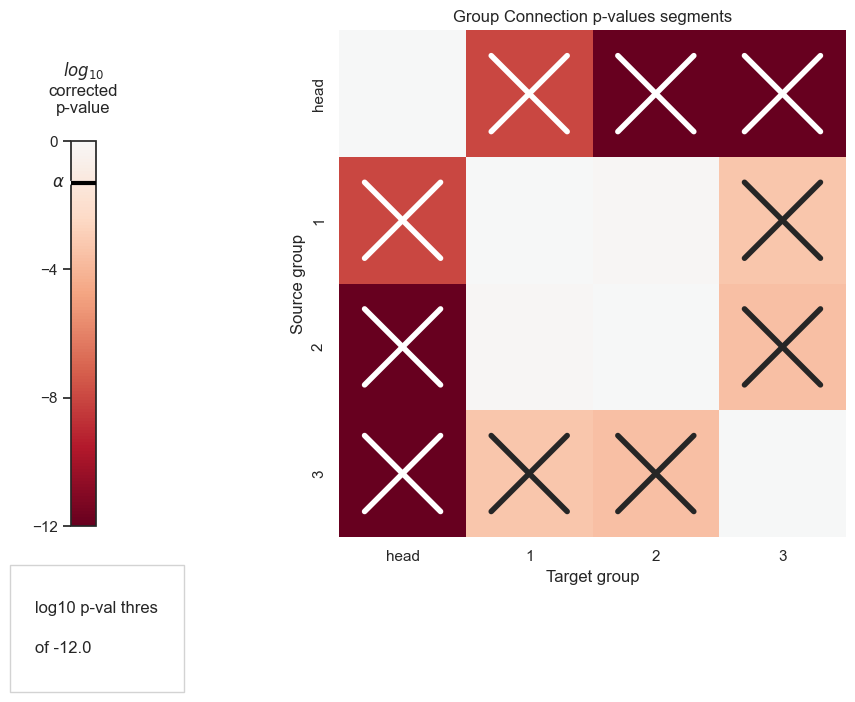

In [30]:
plot_pvals(df=pval_df, names=segment_names, density_correct=False, bonferroni_correct=False, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_v2")

0, 1
7.666231735412694e-08, -16.383855548464105
head, 1

0, 2
1.1999999999934e-11, -25.14611446614605
head, 2

0, 3
1.1999999999934e-11, -25.14611446614605
head, 3

1, 0
7.666231735412694e-08, -16.383855548464105
1, head

1, 3
0.0018349762943948107, -6.300723716144983
1, 3

2, 0
1.1999999999934e-11, -25.14611446614605
2, head

2, 3
0.001351941457496195, -6.606213602967361
2, 3

3, 0
1.1999999999934e-11, -25.14611446614605
3, head

3, 1
0.0018349762943948107, -6.300723716144983
3, 1

3, 2
0.001351941457496195, -6.606213602967361
3, 2



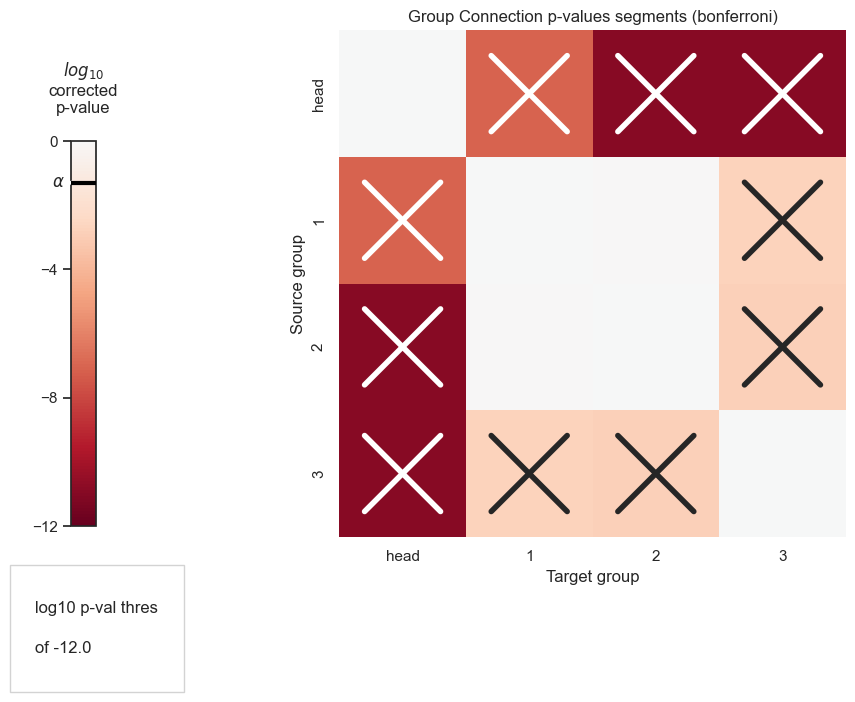

In [31]:
plot_pvals(df=pvals_df_bonferroni_corrected, names=segment_names, density_correct=False, bonferroni_correct=True, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_bonferroni_corrected_v2")

0, 1
4.478637772421832e-07, -14.618776719425513
head, 1

0, 2
1e-12, -27.63102111592855
head, 2

0, 3
1e-12, -27.63102111592855
head, 3

1, 0
4.478637772421832e-07, -14.618776719425513
1, head

1, 3
0.00010077644295252392, -9.202605930507127
1, 3

2, 0
1e-12, -27.63102111592855
2, head

2, 3
0.000360447329877368, -7.928164714888751
2, 3

3, 0
1e-12, -27.63102111592855
3, head

3, 1
0.00010077644295252392, -9.202605930507127
3, 1

3, 2
0.000360447329877368, -7.928164714888751
3, 2



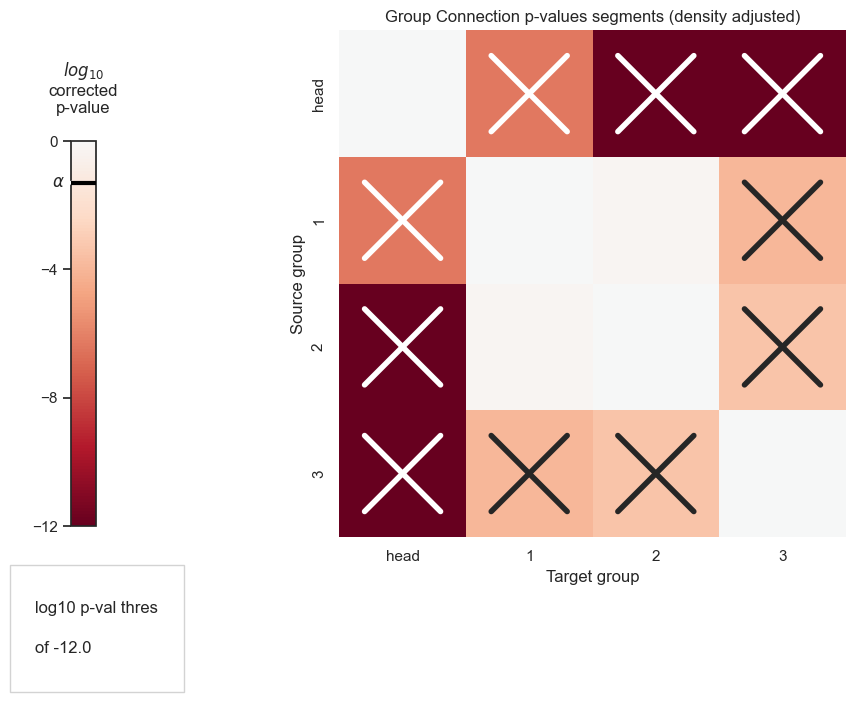

In [32]:
plot_pvals(df=pval_df_density_correct, names=segment_names, density_correct=True, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_density_adjusted_v2")

0, 1
3.5829046016475335e-06, -12.539336745268722
head, 1

0, 2
1.1999999999934e-11, -25.14611446614605
head, 2

0, 3
1.1999999999934e-11, -25.14611446614605
head, 3

1, 0
3.5829046016475335e-06, -12.539336745268722
1, head

1, 3
0.0006045063398112763, -7.411098400270003
1, 3

2, 0
1.1999999999934e-11, -25.14611446614605
2, head

2, 3
0.00144100997314745, -6.542411040998105
2, 3

3, 0
1.1999999999934e-11, -25.14611446614605
3, head

3, 1
0.0006045063398112763, -7.411098400270003
3, 1

3, 2
0.00144100997314745, -6.542411040998105
3, 2



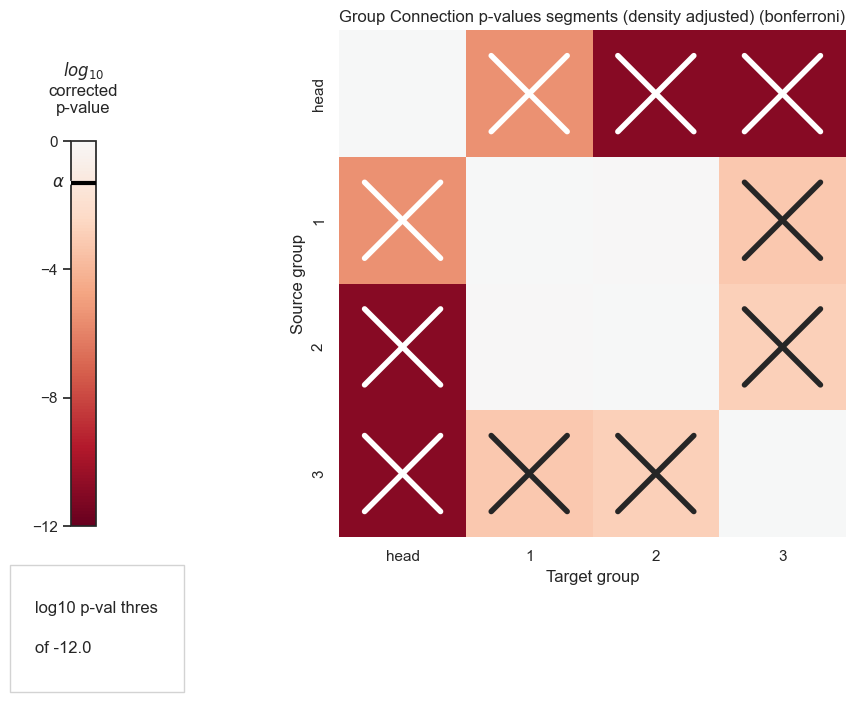

In [33]:
plot_pvals(df=pvals_df_density_corrected_bonferroni_corrected, names=segment_names, density_correct=True, bonferroni_correct=True, thres=thres)
#plt.savefig(new_folder / "group_connection_heatmap_segments_density_adjusted_bonferroni_corrected_v2")

The following section will look at comparisons of the B matrices of left vs right, and of the head, seg 1, and seg 2 using the density adjusted test

In [34]:
from pkg.plot import plot_stochastic_block_probabilities, set_theme, bound_texts
from pkg.data import load_network_palette, load_node_palette, load_unmatched
neutral_color = sns.color_palette("Set2")[2]
network_palette, NETWORK_KEY = load_network_palette()

In [49]:
def plot_stochastic_block_probabilities(misc, network_palette, name1, name2, paired=False):
    # get values
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    if not paired:
        null_odds = misc["null_ratio"]
    else:
        null_odds = 1.0
    B2 = B2 * null_odds

    p_max = max(B1.values.max(), B2.values.max())
    K = B1.shape[0]

    # set up plot
    pad = 2
    width_ratios = [0.5, pad + 0.8, 10, pad, 10]
    set_theme(font_scale=1.25)
    fig, axs = plt.subplots(
        1,
        len(width_ratios),
        figsize=(20, 10),
        gridspec_kw=dict(
            width_ratios=width_ratios,
        ),
    )
    left_col = 2
    right_col = 4
    # pvalue_col = 6

    heatmap_kws = dict(
        cmap="Blues", square=True, cbar=False, vmax=p_max, fmt="s", xticklabels=True
    )

    # heatmap of left connection probabilities
    annot = np.full((K, K), "")
    annot[B1.values == 0] = 0
    ax = axs[left_col]
    sns.heatmap(B1, ax=ax, annot=annot, **heatmap_kws)
    ax.set(ylabel="Source group", xlabel="Target group")
    first_text = r"$\hat{B}$ "
    first_text = first_text + name1
    ax.set_title(first_text, fontsize="xx-large", color=network_palette["Left"])

    # heatmap of right connection probabilities
    annot = np.full((K, K), "")
    annot[B2.values == 0] = 0
    ax = axs[right_col]
    im = sns.heatmap(B2, ax=ax, annot=annot, **heatmap_kws)
    ax.set(ylabel="", xlabel="Target group")
    second_text = r"$\hat{B}$ "
    second_text = second_text + name2
    if null_odds != 1:
        second_text = r"$c$" + second_text
    ax.set_title(second_text, fontsize="xx-large", color=network_palette["Right"])
    # ax.set(yticks=[], yticklabels=[])

    # handle the colorbars
    # NOTE: did it this way cause the other options weren't playing nice with auto
    # constrain
    # layouts.

    ax = axs[0]
    shrink_axis(ax, scale=0.5)
    _ = fig.colorbar(
        im.get_children()[0],
        cax=ax,
        fraction=1,
        shrink=1,
        ticklocation="left",
    )
    ax.set_title("Estimated\nedge\nprobability", y=1.1)

    # remove dummy axes
    for i in range(len(width_ratios)):
        if not axs[i].has_data():
            axs[i].set_visible(False)

    ax = axs[left_col]
    
    """
    texts = []
    texts.append(ax.text(-0.6, -0.15, "0 - No edges", transform=ax.transAxes))
    texts.append(ax.text(-0.51, -0.23, "observed", transform=ax.transAxes))

    bound_texts(
        texts, ax=ax, facecolor="white", edgecolor="lightgrey", xpad=0.2, ypad=0.8
    )
    """

    return fig, axs

In [59]:
def plot_estimated_probabilities(misc, name1, name2, paired=False):
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    if not paired:
        null_odds = misc["null_ratio"]
    else:
        null_odds = 1
    B2 = B2 * null_odds
    B1_ravel = B1.values.ravel()
    B2_ravel = B2.values.ravel()
    arange = np.arange(len(B1_ravel))
    sum_ravel = B1_ravel + B2_ravel
    sort_inds = np.argsort(-sum_ravel)
    B1_ravel = B1_ravel[sort_inds]
    B2_ravel = B2_ravel[sort_inds]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    ax = axs[0]
    sns.scatterplot(
        x=arange,
        y=B1_ravel,
        color=network_palette["Left"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
    )
    sns.scatterplot(
        x=arange,
        y=B2_ravel,
        color=network_palette["Right"],
        ax=ax,
        linewidth=0,
        s=15,
        alpha=0.5,
        zorder=-1,
    )
    ax.text(
        0.7,
        0.8,
        f"{name1}",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    ax.text(
        0.7,
        0.7,
        f"{name2}",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )
    ax.set_yscale("log")
    ax.set(
        ylabel="Estimated probability " + r"($\hat{p}$)",
        xticks=[],
        xlabel="Sorted group pairs",
    )
    ax.spines["bottom"].set_visible(False)

    ax = axs[1]
    diff = B1_ravel - B2_ravel
    yscale = np.max(np.abs(diff))
    yscale *= 1.05
    sns.scatterplot(
        x=arange, y=diff, ax=ax, linewidth=0, s=25, color=neutral_color, alpha=1
    )
    ax.axhline(0, color="black", zorder=-1)
    ax.spines["bottom"].set_visible(False)
    ax.set(
        xticks=[],
        ylabel=r"$\hat{p}_{left} - \hat{p}_{right}$",
        xlabel="Sorted group pairs",
        ylim=(-yscale, yscale),
    )
    n_greater = np.count_nonzero(diff > 0)
    n_total = len(diff)
    ax.text(
        0.3,
        0.8,
        f"{name1} connection stronger ({n_greater}/{n_total})",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    n_lesser = np.count_nonzero(diff < 0)
    ax.text(
        0.3,
        0.15,
        f"{name2} connection stronger ({n_lesser}/{n_total})",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )

    fig.text(0.02, 0.905, "A)", fontweight="bold", fontsize=30)
    fig.text(0.02, 0.49, "B)", fontweight="bold", fontsize=30)

    return fig, ax

In [37]:
from seaborn.utils import relative_luminance
from pkg.plot import bound_texts
import matplotlib as mpl
def plot_pvals_v2(df, density_correct=True, bonferroni_correct=False, ax=None, thres=None, title=None, check_diag = False):
    names = df.index
    if ax is None:
        width_ratios = [0.5, 3, 10]
        fig, axs = plt.subplots(
            1,
            3,
            figsize=(10, 10),
            gridspec_kw=dict(
                width_ratios=width_ratios,
            ),
        )
        axs[1].remove()
        ax = axs[-1]
        cax = axs[0]
    
    plot_pvalues = np.log10(df)
    plot_pvalues.replace(-np.inf, 0, inplace=True)
    im = sns.heatmap(
        plot_pvalues,
        ax=ax,
        cmap="RdBu",
        center=0,
        square=True,
        cbar=False,
        vmin=np.log10(thres),
        fmt="s",
    )

    if title is not None:
        title = title
    else:
        title = "Group Connection p-values segments"
        if density_correct == True:
            title += " (density adjusted)"

        if bonferroni_correct == True:
            title += " (bonferroni)"

    ax.set(ylabel="Source group", xlabel="Target group", title=title)
    ax.set(xticks=np.arange(len(names)) + 0.5, xticklabels=names)
    
    colors = im.get_children()[0].get_facecolors()
    #print(colors)
    shrink_axis(cax, scale=0.5, shift=0.05)
    
    fig = ax.get_figure()

    
    if thres is None:
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticklocation="left",
        )

    else:
        
        cb = fig.colorbar(
            im.get_children()[0],
            cax=cax,
            fraction=1,
            shrink=1,
            ticks=np.linspace(np.log10(thres), 0, 4), #[-12, -8, -4, 0]
            ticklocation="left",
        )
        
        
        """
        cmap = mpl.cm.RdBu
        vmax=0
        vmin=np.log10(thres)
        center=0
        vrange = max(vmax - center, center - vmin)
        normlize = mpl.colors.Normalize(center - vrange, center + vrange)
        cmin, cmax = normlize([vmin, vmax])
        cc = np.linspace(cmin, cmax, 256)
        cmap = mpl.colors.ListedColormap(cmap(cc))

        fig.colorbar(mpl.cm.ScalarMappable(norm=normlize, cmap=cmap),
        cax=cax, orientation='vertical')
        """
        texts = []
        texts.append(ax.text(-0.6, -0.15, "log10 p-val thres", transform=ax.transAxes))
        texts.append(ax.text(-0.6, -0.23, f"of {np.log10(thres)}", transform=ax.transAxes))
        
        bound_texts(
            texts, ax=ax, facecolor="white", edgecolor="lightgrey", xpad=0.2, ypad=0.4
        )
    
    cax.set_title(r"$log_{10}$" + "\ncorrected" "\np-value", pad=20)
    
    cax.plot(
        [0, 1], [np.log10(0.05), np.log10(0.05)], zorder=100, color="black", linewidth=3
    )
    
    cax.annotate(
        r"$\alpha$",
        (0.05, np.log10(0.05)),
        xytext=(-5, 0),
        textcoords="offset points",
        va="center",
        ha="right",
        arrowprops={"arrowstyle": "-", "linewidth": 3, "relpos": (0, 0.5)},
    )
    
    #make X's
    pad=0.2
    for idx, color in enumerate(colors):
        i, j = np.unravel_index(idx, (len(names), len(names)))
        #index correctly using loc
        if df.loc[names[i], names[j]] < 0.05:
            print(f'{df.loc[names[i], names[j]]}, {np.log(df.loc[names[i], names[j]])}')
            print("{}, {}".format(names[i], names[j]))
            print()
            lum = relative_luminance(color)
            text_color = ".15" if lum > 0.408 else "w"

            xs = [j + pad, j + 1 - pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)
            xs = [j + 1 - pad, j + pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)


In [38]:
#test with left and right
np_left = np.array(left_adj)
np_right = np.array(right_adj)
stat, pvalue, misc_lr = stochastic_block_test(
    np_left,
    np_right,
    labels1=left_labels,
    labels2=right_labels,
    density_adjustment=True,
)


In [39]:
#function to rename and realign misc["probabilities1"] and misc["probabilities2"]

names = ["Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated"]

def convert_misc_format_prob(misc):

    #probabilities1 and probabilities2
    zero_data = np.zeros(shape=(len(names), len(names)))
    B1 = pd.DataFrame(zero_data, columns=names, index=names)
    B2 = pd.DataFrame(zero_data, columns=names, index=names)
    for i in range(len(B1)):
        for j in range(len(B1.columns)):
            B1.loc[names[j], names[j]] = misc["probabilities1"].loc[names[j].lower(), names[i].lower()]
            B2.loc[names[j], names[j]] = misc["probabilities2"].loc[names[j].lower(), names[i].lower()]
    return B1, B2



In [40]:
#format B1 and B2
#B1_lr, B2_lr = convert_misc_format_prob(misc_lr)
#print(B1_lr)
#print(B2_lr)
#misc_lr_dup = misc_lr.copy()
#misc_lr_dup["probabilities1"] = B1_lr
#misc_lr_dup["probabilities2"] = B2_lr

print(misc_lr["probabilities1"])
print(misc_lr["probabilities2"])

target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
inter      0.000654   0.000873  0.006404  0.006990  0.000014  0.001777
motor      0.017222   0.002667  0.002277  0.009394  0.005676  0.000602
muscle     0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
sensory    0.000335   0.000268  0.005488  0.003735  0.000130  0.005360
target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000110
epithelia  0.000000   0.000000  0.000000  0.000000  0.000000  0.000418
inter      0.000483   0.001050  0.006354  0.006524  0.000018  0.001834
motor      0.014787   0.006667  0.002225  0.010165  0.006262  0.000757
muscle

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ left'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ right'}, xlabel='Target group'>],
       dtype=object))

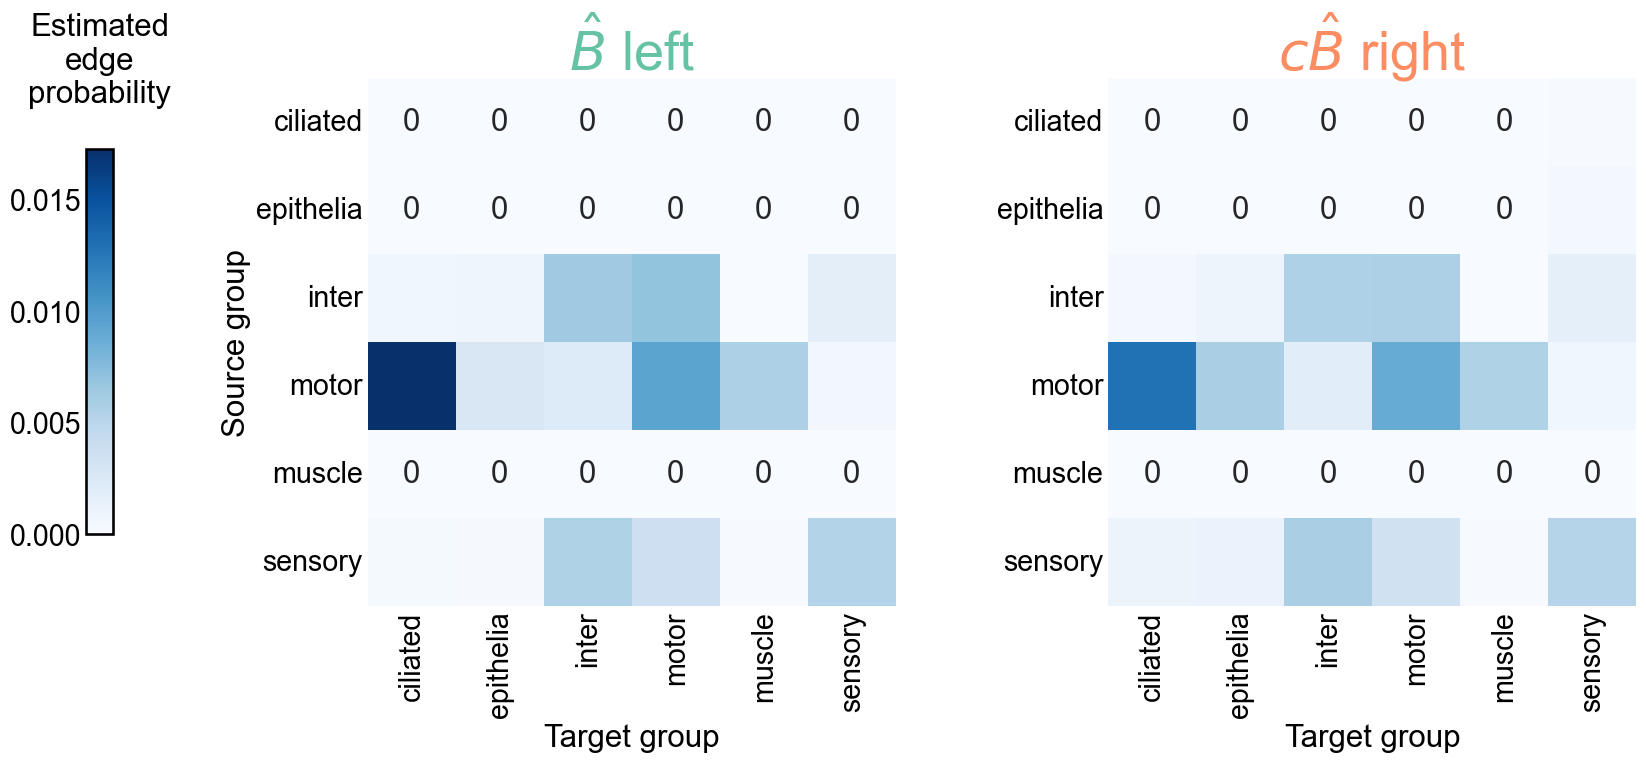

In [41]:
plot_stochastic_block_probabilities(misc_lr, network_palette, "left", "right")

In [42]:
lr_pvals = misc_lr["corrected_pvalues"]
lr_pvals


target,ciliated,epithelia,inter,motor,muscle,sensory
source,,,,,,
ciliated,NaN,NaN,NaN,NaN,NaN,NaN
epithelia,NaN,NaN,NaN,NaN,NaN,NaN
inter,1.0,1.0,0.029191,0.285407,1.0,1.0
motor,1.0,1.0,1.000000,1.000000,1.0,1.0
muscle,NaN,NaN,NaN,NaN,NaN,NaN
sensory,1.0,1.0,1.000000,1.000000,1.0,1.0


In [43]:
names = ["Sensory", "Inter", "Motor", "Muscle", "Epithelia", "Ciliated"]

def convert_misc_format_pval(pval_df):
    zero_data = np.zeros(shape=(len(names), len(names)))
    pval_df_convert = pd.DataFrame(zero_data, columns=names, index=names)
    for i in range(len(pval_df)):
        for j in range(len(pval_df.columns)):
            pval_df_convert[names[i]][names[j]] = pval_df[names[i].lower()][names[j].lower()]
    
    return pval_df_convert


lr_pvals.columns = lr_pvals.columns.str.capitalize()
lr_pvals.index = lr_pvals.index.str.capitalize()
lr_pvals

target,Ciliated,Epithelia,Inter,Motor,Muscle,Sensory
source,,,,,,
Ciliated,NaN,NaN,NaN,NaN,NaN,NaN
Epithelia,NaN,NaN,NaN,NaN,NaN,NaN
Inter,1.0,1.0,0.029191,0.285407,1.0,1.0
Motor,1.0,1.0,1.000000,1.000000,1.0,1.0
Muscle,NaN,NaN,NaN,NaN,NaN,NaN
Sensory,1.0,1.0,1.000000,1.000000,1.0,1.0


0.029190892066553863, -3.533898533892645
Inter, Inter



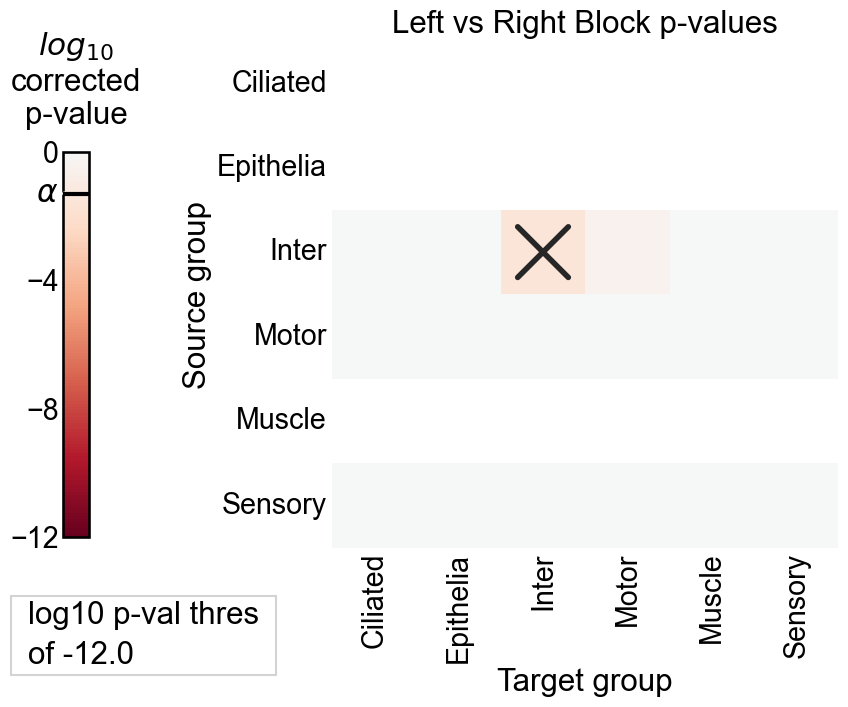

In [44]:
# lr_df_convert = convert_misc_format_pval(lr_pvals)
plot_pvals_v2(lr_pvals, names, title="Left vs Right Block p-values", thres = thres, check_diag = True)

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

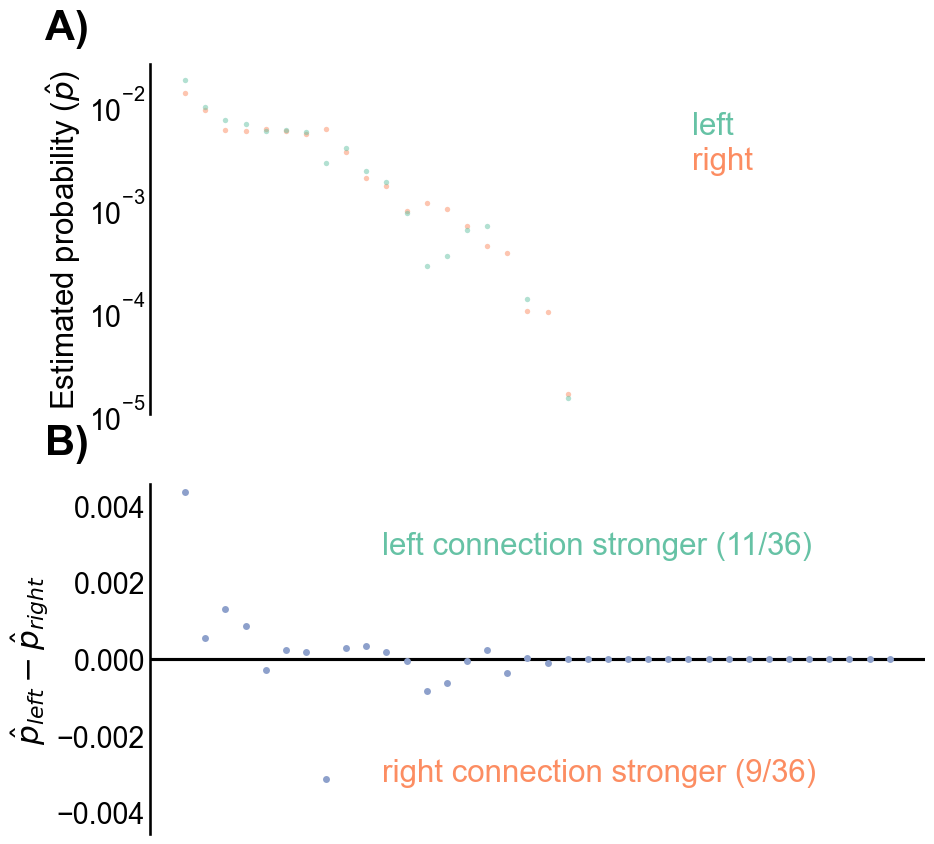

In [45]:
plot_estimated_probabilities(misc_lr, "left", "right")

In [60]:
#NOTE: MAKE THESE THREE FIGS FOR BEST LEFT VS RIGHT
#test with left and right
np_left_best = np.array(best_left_adj)
np_right_best = np.array(best_right_adj)
stat_best, pvalue_best, misc_lr_best = stochastic_block_test_paired(
    np_left_best,
    np_right_best,
    labels = best_left_labels,
)

misc_lr_best

{'both': target     ciliated  epithelia  inter  motor  muscle  sensory
 source                                                       
 ciliated          0          0      0      0       0        0
 epithelia         0          0      0      0       0        0
 inter             0          0    207     63       0       17
 motor            36          0      8     16      38        0
 muscle            0          0      0      0       0        0
 sensory           2          0    166     22       1       86,
 'neither': target     ciliated  epithelia   inter  motor  muscle  sensory
 source                                                        
 ciliated        870        150    9780   2190    3870     6240
 epithelia       150         20    1630    365     645     1040
 inter          9779       1629  104824  23537   42053    67616
 motor          2139        363   23712   5161    9349    15169
 muscle         3870        645   42054   9417   16512    26832
 sensory        6233       1

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ Left Best'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ Right Best'}, xlabel='Target group'>],
       dtype=object))

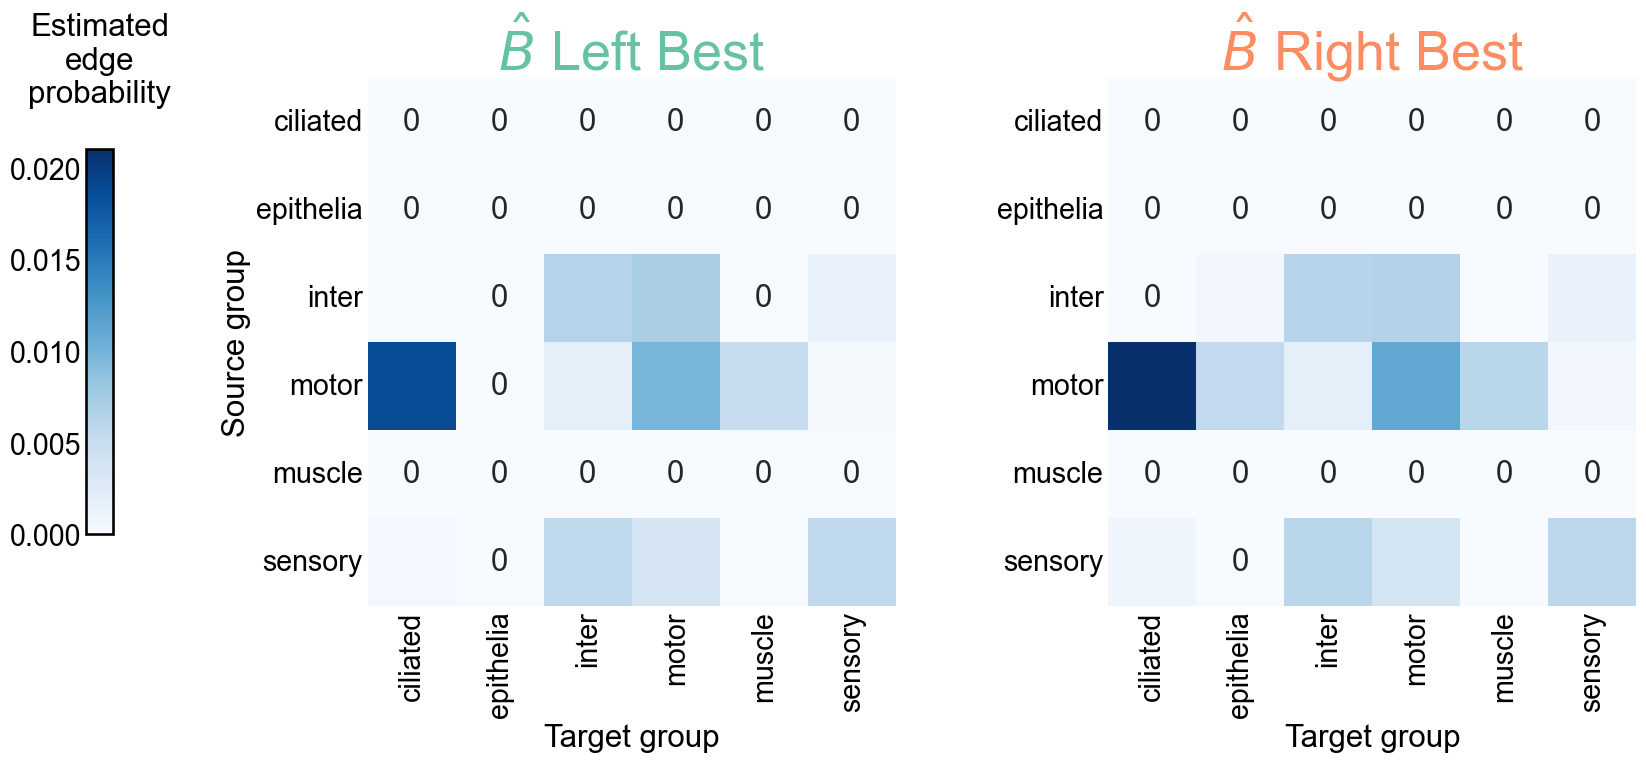

In [50]:
plot_stochastic_block_probabilities(misc_lr_best, network_palette, "Left Best", "Right Best", paired=True)

In [61]:
best_lr_pvals = misc_lr_best["corrected_pvalues"]

best_lr_pvals.columns = best_lr_pvals.columns.str.capitalize()
best_lr_pvals.index = best_lr_pvals.index.str.capitalize()
best_lr_pvals

target,Ciliated,Epithelia,Inter,Motor,Muscle,Sensory
source,,,,,,
Ciliated,1.0,1.0,1.0,1.0,1.0,1.0
Epithelia,1.0,1.0,1.0,1.0,1.0,1.0
Inter,1.0,1.0,1.0,1.0,1.0,1.0
Motor,1.0,1.0,1.0,1.0,1.0,1.0
Muscle,1.0,1.0,1.0,1.0,1.0,1.0
Sensory,1.0,1.0,1.0,1.0,1.0,1.0


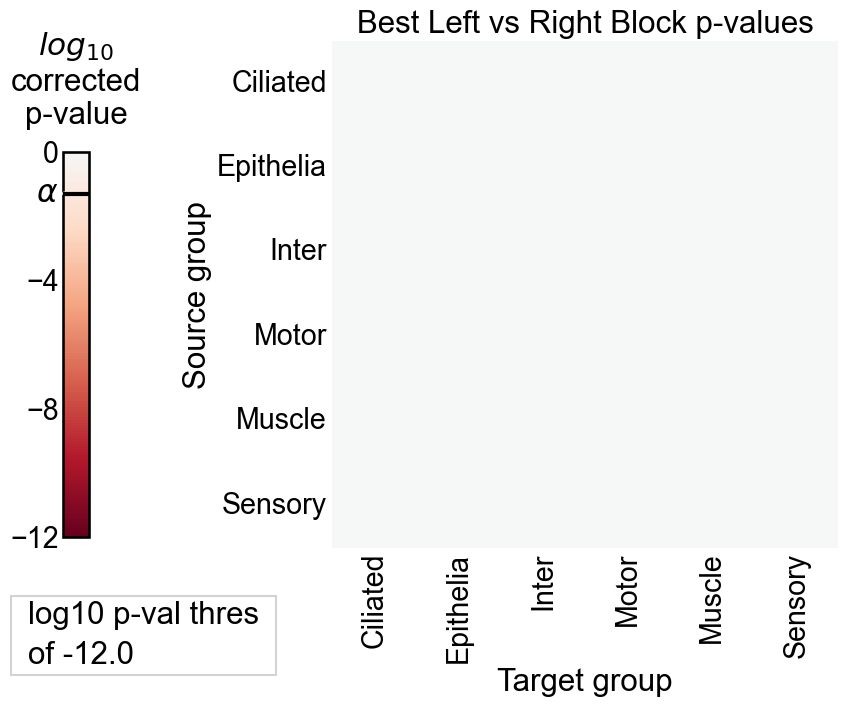

In [57]:
plot_pvals_v2(best_lr_pvals, names, title="Best Left vs Right Block p-values", thres = thres, check_diag = True)

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

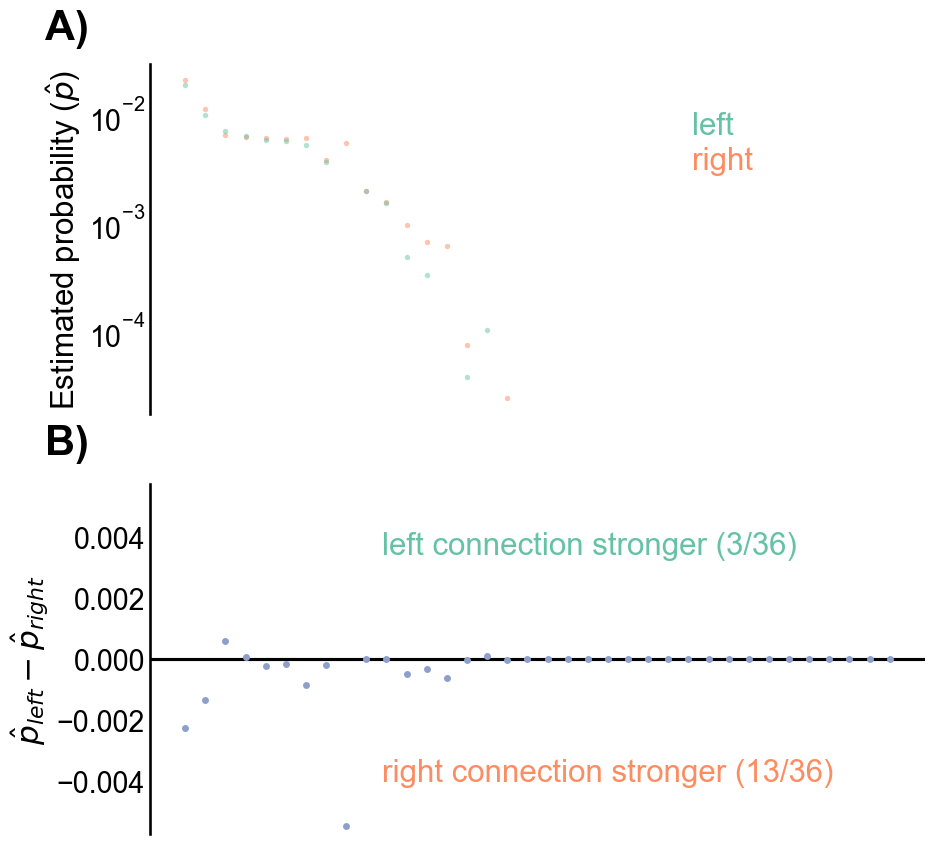

In [62]:
plot_estimated_probabilities(misc_lr_best, "left", "right", paired=True)

head vs seg 1

In [63]:
np_head = np.array(head_adj)
np_seg1 = np.array(adj_1)
stat, pvalue, misc_h1 = group_connection_test(
    np_head,
    np_seg1,
    labels1=head_labels,
    labels2=labels_1,
    density_adjustment=True
)
print(misc_h1["probabilities1"])
print(misc_h1["probabilities2"])

target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000        0.0  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000        0.0  0.000000  0.000000  0.000000  0.000000
inter      0.003269        0.0  0.009727  0.024914  0.000416  0.001263
motor      0.111570        0.0  0.009276  0.064935  0.006494  0.001013
muscle     0.000000        0.0  0.000000  0.000000  0.000000  0.000000
sensory    0.000579        0.0  0.006082  0.011870  0.001365  0.006105
target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
inter      0.000000   0.000000  0.010097  0.012021  0.000000  0.002444
motor      0.035377   0.009434  0.004413  0.017417  0.021202  0.000572
muscle

/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)
/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:376: UserWarning: This test assumes that the networks are loopless, but one or both adjacency matrices have self-loops.Test will be run on the loopless version of these adjacency matrices.
  warnings.warn(msg)


In [64]:
#format B1 and B2
#B1_h1, B2_h1 = convert_misc_format_prob(misc_h1)

#misc_h1_dup = misc_h1.copy()
#misc_h1_dup["probabilities1"] = B1_h1
#misc_h1_dup["probabilities2"] = B2_h1

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ head'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ segment 1'}, xlabel='Target group'>],
       dtype=object))

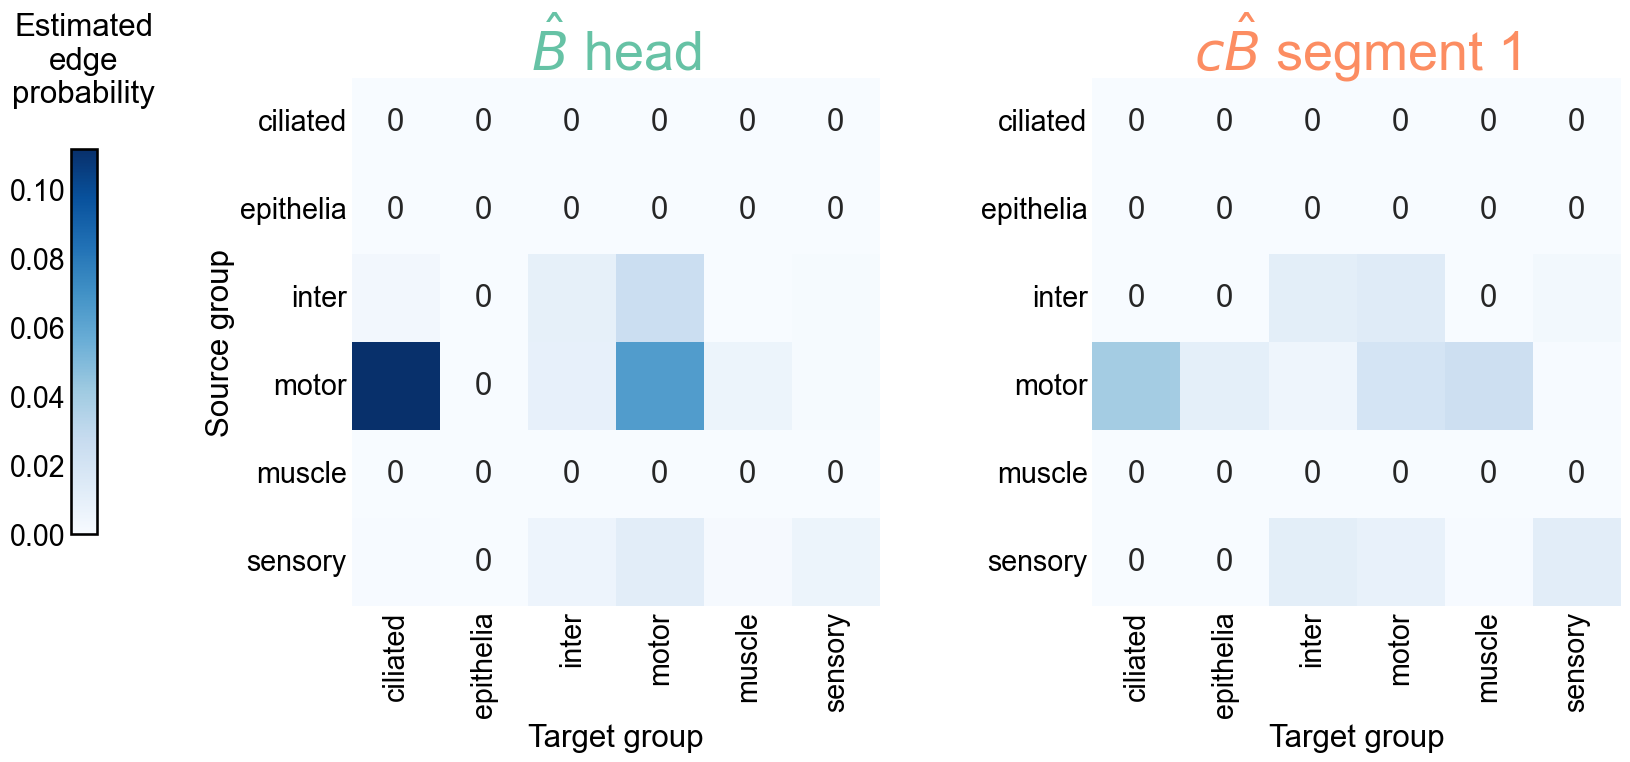

In [65]:
plot_stochastic_block_probabilities(misc_h1, network_palette, "head", "segment 1")

In [66]:
h1_pvals = misc_h1["corrected_pvalues"]
h1_pvals.columns = h1_pvals.columns.str.capitalize()
h1_pvals.index = h1_pvals.index.str.capitalize()
h1_pvals

target,Ciliated,Epithelia,Inter,Motor,Muscle,Sensory
source,,,,,,
Ciliated,NaN,NaN,NaN,NaN,NaN,NaN
Epithelia,NaN,NaN,NaN,NaN,NaN,NaN
Inter,NaN,NaN,0.714277,4.470257e-05,NaN,0.168952
Motor,0.000875,NaN,0.050844,4.478639e-07,1.0,1.000000
Muscle,NaN,NaN,NaN,NaN,NaN,NaN
Sensory,NaN,NaN,0.000405,1.000000e+00,1.0,0.327574


In [67]:
"""
h1_pvals_conv = h1_pvals.copy()
for rowIndex, row in h1_pvals.iterrows(): #iterate over rows
    for columnIndex, value in row.items(): 
        if value < thres:
            h1_pvals_conv[columnIndex][rowIndex] = thres
h1_pvals_conv
"""

'\nh1_pvals_conv = h1_pvals.copy()\nfor rowIndex, row in h1_pvals.iterrows(): #iterate over rows\n    for columnIndex, value in row.items(): \n        if value < thres:\n            h1_pvals_conv[columnIndex][rowIndex] = thres\nh1_pvals_conv\n'

4.470256632467307e-05, -10.015479645807687
Inter, Motor

0.000875465122289566, -7.040755244508125
Motor, Ciliated

4.478638691756093e-07, -14.618776514154579
Motor, Motor

0.0004047043066621348, -7.812353864522731
Sensory, Inter



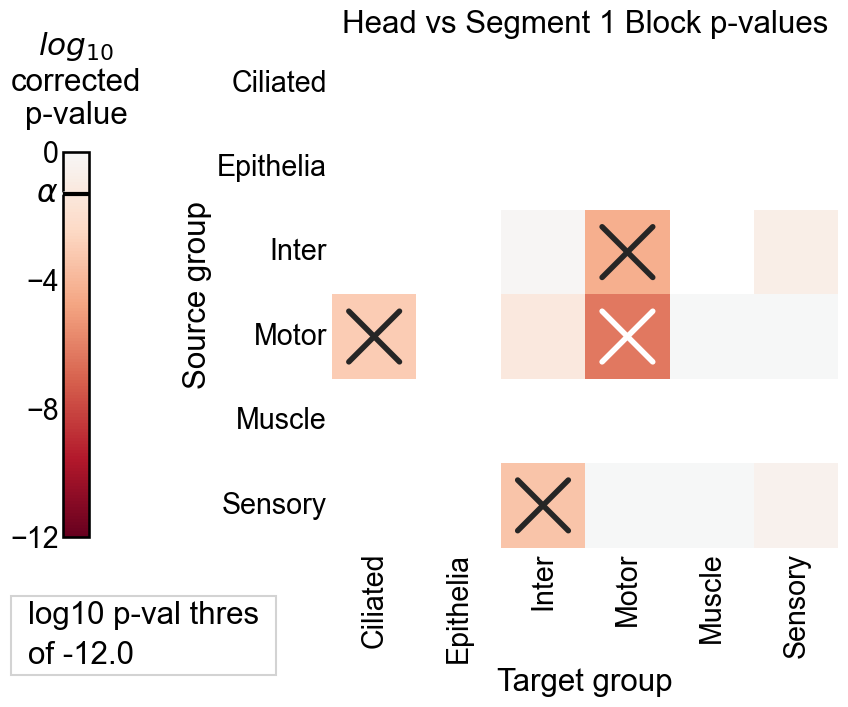

In [68]:
#h1_df_convert = convert_misc_format_pval(h1_pvals)
plot_pvals_v2(h1_pvals, names, title="Head vs Segment 1 Block p-values", thres=thres, check_diag=True)

(<Figure size 1000x1000 with 2 Axes>,
 <AxesSubplot:xlabel='Sorted group pairs', ylabel='$\\hat{p}_{left} - \\hat{p}_{right}$'>)

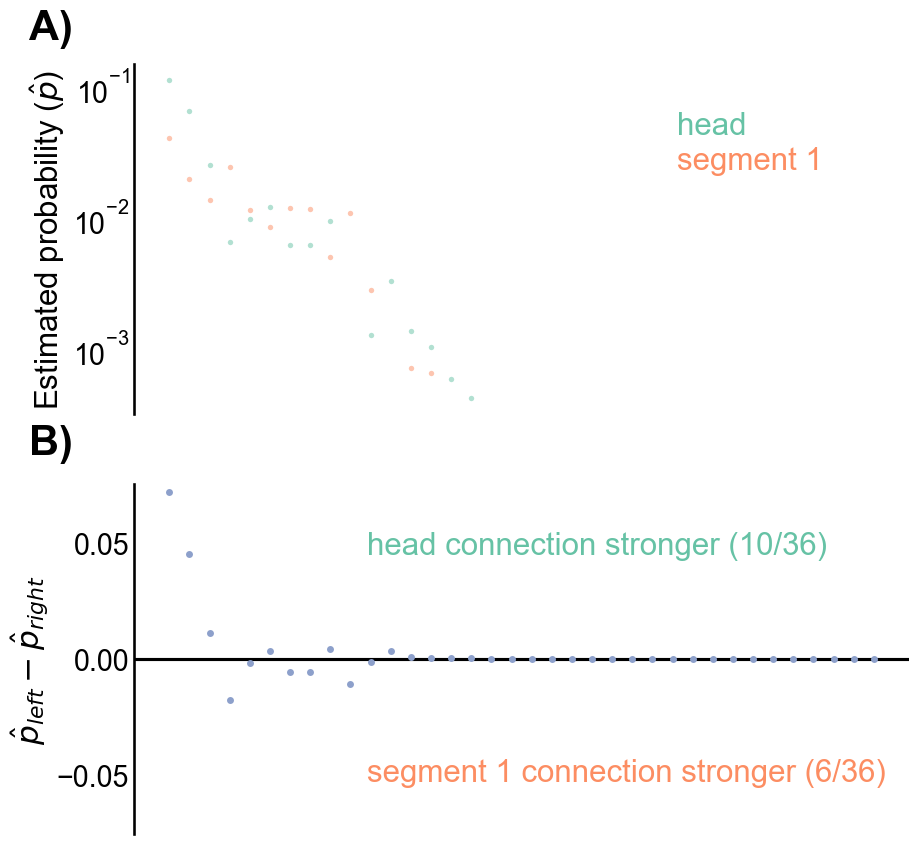

In [69]:
plot_estimated_probabilities(misc_h1, "head", "segment 1")

seg 1 vs seg 2

In [70]:
np_seg1 = np.array(adj_1)
np_seg2 = np.array(adj_2)
stat, pvalue, misc_12 = group_connection_test(
    np_seg1,
    np_seg2,
    labels1=labels_1,
    labels2=labels_2,
    density_adjustment=True
)

print(misc_12["probabilities1"])
print(misc_12["probabilities2"])

target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
inter      0.000000   0.000000  0.010097  0.012021  0.000000  0.002444
motor      0.035377   0.009434  0.004413  0.017417  0.021202  0.000572
muscle     0.000000   0.000000  0.000000  0.000000  0.000000  0.000000
sensory    0.000000   0.000000  0.010264  0.007433  0.000625  0.010417
target     ciliated  epithelia     inter     motor    muscle   sensory
source                                                                
ciliated        0.0   0.000000  0.000000  0.000000  0.000000  0.000000
epithelia       0.0        NaN  0.000000  0.000000  0.000000  0.000000
inter           0.0   0.000000  0.010907  0.011844  0.000060  0.003424
motor           0.0   0.013889  0.003153  0.013889  0.024237  0.002907
muscle

/Users/kareefullah/Desktop/NeuroData/neurodata/graspologic/graspologic/inference/group_connection_test.py:369: UserWarning: This test assumes that the networks are unweighted, but one or both adjacency matrices are weighted.Test will be run on the binarized version of these adjacency matrices.
  warnings.warn(msg)


In [71]:
#format B1 and B2
#B1_12, B2_12 = convert_misc_format_prob(misc_12)
#misc_12_dup = misc_12.copy()
#misc_12_dup["probabilities1"] = B1_12
#misc_12_dup["probabilities2"] = B2_12

(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Estimated\nedge\nprobability'}>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$\\hat{B}$ segment 1'}, xlabel='Target group', ylabel='Source group'>,
        <AxesSubplot:>,
        <AxesSubplot:title={'center':'$c$$\\hat{B}$ segment 2'}, xlabel='Target group'>],
       dtype=object))

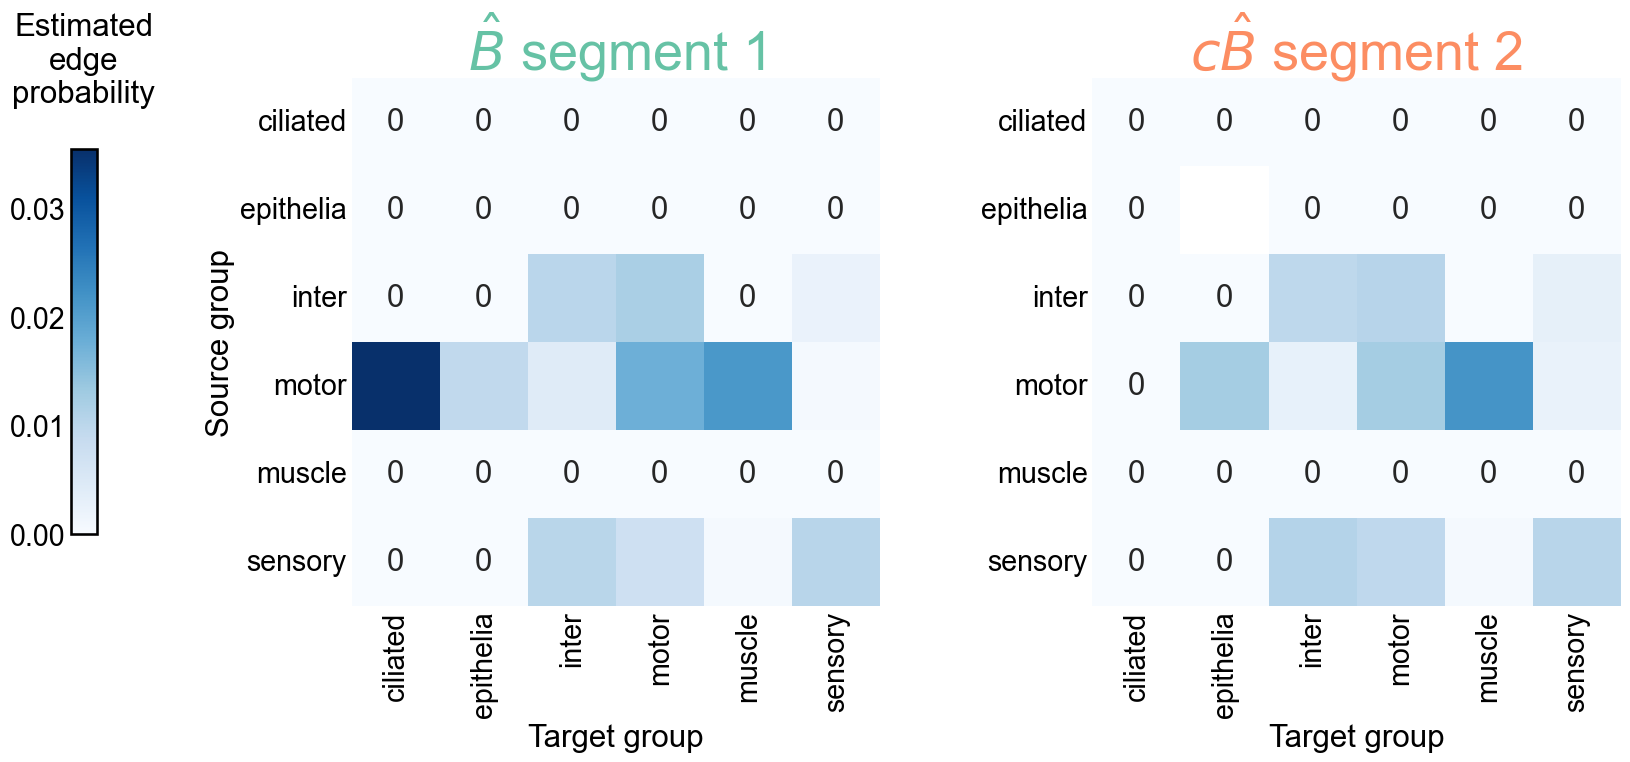

In [72]:
plot_stochastic_block_probabilities(misc_12, network_palette, "segment 1", "segment 2")

In [73]:
seg12_pvals = misc_12["corrected_pvalues"]
seg12_pvals
seg12_pvals.columns = seg12_pvals.columns.str.capitalize()
seg12_pvals.index = seg12_pvals.index.str.capitalize()
seg12_pvals

target,Ciliated,Epithelia,Inter,Motor,Muscle,Sensory
source,,,,,,
Ciliated,NaN,NaN,NaN,NaN,NaN,NaN
Epithelia,NaN,NaN,NaN,NaN,NaN,NaN
Inter,NaN,NaN,1.000000,1.000000,NaN,1.0
Motor,NaN,1.0,0.842221,0.837968,1.0,1.0
Muscle,NaN,NaN,NaN,NaN,NaN,NaN
Sensory,NaN,NaN,1.000000,1.000000,1.0,1.0


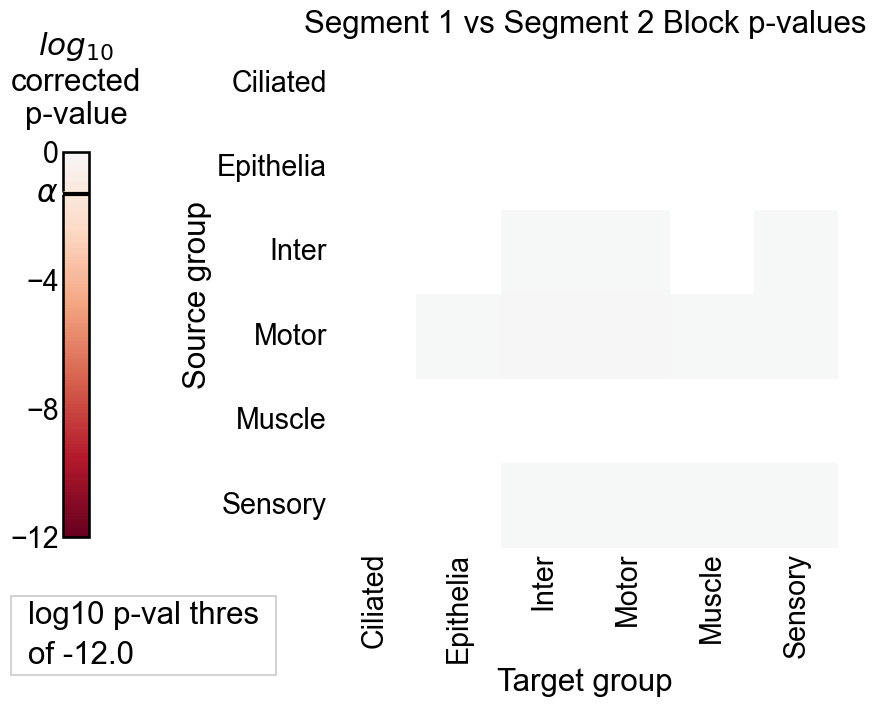

In [74]:
#seg12_df_convert = convert_misc_format_pval(seg12_pvals)
plot_pvals_v2(seg12_pvals, names, title="Segment 1 vs Segment 2 Block p-values", thres=thres, check_diag=True)

In [76]:
#plot_estimated_probabilities(misc_12, "segment 1", "segment 2")

Fix colorbar everywhere (all heatmaps of pvalues in density/sbms)



Something wrong with group_connection test pvals...? Because I am just taking the pvals from misc

Uncorrected vs corrected pvals

X's not showing in some places where they should

Use loc to index and rerun sbm tests

Fix colorbar to original version (have it consistent across all figs)

Change lab meeting to 5/15?

Get final figs and publish to overleaf

Work on presentation

Discuss paper

List of grad schools

Graph Matching:
Use weighted networks
param n_init: governs how many restarts to do (can set as 10: 2 minutes to run)
compute an accuracy compared to what nadine said: compute proportion of how many pairings of our matching (using perm_inds) was similar to nadine's
try in left vs right
